##  Adv Machine Learning project - FHNW Data Science Specialization module

============================

# 1 Import libraries

In [311]:
# Remove warning about future deprecation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 


# data manipulation
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import re
from functools import reduce

# Unblanaced dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, SMOTEN, SVMSMOTE, BorderlineSMOTE, ADASYN

# Statistical functions
from scipy import stats

# modeling utilities
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, OrdinalEncoder, LabelBinarizer, MultiLabelBinarizer
from sklearn.experimental import enable_iterative_imputer # enables sklearn.impute.IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier, Perceptron
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.ensemble import RandomForestClassifier, StackingClassifier , HistGradientBoostingClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, precision_recall_curve,  confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn import set_config
set_config(display="diagram")

# Additional models
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%matplotlib inline
import seaborn as sns

# misc
from tqdm import tqdm  
from datetime import datetime

# 2 Helper functions and Custom Transformers

In [312]:
class FeatureUnion_CT(BaseEstimator, TransformerMixin):
    """ Same as FeatureUnion Transform but returns a pandas DataFrames

    Returns:
        Xunion: DataFrame
    """

    def __init__(self, transformer_list):
        N = len(transformer_list[0])
        if N == 3:
            self.transformer_list = [(name, model) for (name, model, _) in transformer_list]
        elif N == 2:
            self.transformer_list = [(name, model) for (name, model) in transformer_list]
        else:
            print("Transformer dimension not valid")
            self.transformer_list = None

    def fit(self, X, y=None):
        for (_, model) in self.transformer_list:
            model.fit(X, y)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xts = [model.transform(X) for _, model in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion
    
    
class OHE_CT(BaseEstimator, TransformerMixin):
    """ Same as OneHotEncoder encoder but returns a pandas DataFrames
    Args:
        columns (list of strings): the columns to be encoded
    Returns:
        Xohe_df: DataFrame
    """

    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, df, y=None):
        self.ohe = OneHotEncoder(sparse = False)
        if self.columns==None:
            self.ohe.fit(df)
        else:
            self.ohe.fit(df.loc[:, self.columns])
        return self

    def transform(self, df):
        if self.columns==None:
            Xohe = self.ohe.transform(df)
            self.columns = df.columns
        else:
            Xohe = self.ohe.transform(df.loc[:, self.columns])
        
        index  = []
        for col in self.columns:
            unique_feature_list = df[col].unique().tolist()
            unique_feature_list.sort()
            [index.append(col + "." + feature) for feature in unique_feature_list] 
        
        Xohe_df = pd.DataFrame(Xohe, columns = index)
        return Xohe_df


class OrdinalEncoder_CT(BaseEstimator, TransformerMixin):
    """ Same as OrdinalEncoder encoder but returns a pandas DataFrames
    Args:
        categories (list of strings): sorted list of variable (order matters) 
        columns (list of strings): the columns to be encoded
    Returns:
        Xoe_df: DataFrame
    """

    def __init__(self, categories='auto', columns=None):
        self.categories = categories
        self.columns = columns
        # self.unknown_value = np.nan
    
    def fit(self, df, y=None):
        self.oe = OrdinalEncoder(categories=self.categories, handle_unknown='use_encoded_value', unknown_value=-1)        
        if self.columns==None:
            self.oe.fit(df)
        else:
            self.oe.fit(df.loc[:, self.columns], y=None)
        return self

    def transform(self, df):
        X_df = df.copy()
        if self.columns==None:
            self.columns = X_df.columns
            Xoe = self.oe.transform(df)
        else:
            Xoe = self.oe.transform(df.loc[:, self.columns])
        
        Xoe_df = pd.DataFrame(Xoe, columns=self.columns)
        
        X_df[Xoe_df.columns] = Xoe_df 
        return Xoe_df

class ColumnsLabelBinarizer_CT(BaseEstimator, TransformerMixin):
    """ Same as LabelBinarizer encoder but handles multiple columns and returns a pandas DataFrames
    Args:
        -
    Returns:
        Xlbin_df: DataFrame
    """

    # input multiple cols, implement LBin on each, return combined results in df

    def __init__(self):
        self.lbin = []

    def fit(self, df, y=None):
        columns = df.columns.tolist()
        for i, cname in enumerate(columns):
            lb = LabelBinarizer()
            lb.fit(df[cname])
            self.lbin.append(lb)
        return self

    def transform(self, df):
        # assumes X is a DataFrame
        columns = df.columns.tolist()
        Xlbin_df = pd.DataFrame()
        for i, cname in enumerate(columns):
            lb = self.lbin[i]
            Xlbin = lb.transform(df[cname])
            Xlbin_df[cname] = pd.Series(Xlbin.flatten() , name=cname)
        return Xlbin_df
    
    
class GetDummies_CT(TransformerMixin):
    """ Same as DictVectorizer encoder but handles multiple columns and returns a pandas DataFrames
    Args:
        -
    Returns:
        Xlbin_df: DataFrame
    """

    def __init__(self):
        self.dv = None

    def fit(self, X, y=None):
        # assumes all columns of X are strings
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        # drop column indicating NaNs
        nan_cols = [c for c in cols if '=' not in c]
        Xdum = Xdum.drop(nan_cols, axis=1)
        return Xdum
    
class ColumnExtractor_CT(TransformerMixin):
    """ Hanldes columns from a Dataframe, pass them to the next transformer, returns a pandas DataFrames
    Args:
        -
    Returns:
        Xcols: DataFrame
    """
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols
    
class GroupFeatureValues_CT(BaseEstimator, TransformerMixin):
    """ Group several values within a dataframe column by renaming the values, returns pandas DataFrames
    Args:
        features_dict_list: dictionnary including the group name as key and a list of feature values to be grouped
    Returns:
        df_t: DataFrame
    """

    def __init__(self, features_dict_list):
        self.features_dict_list = features_dict_list

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, df):
        df_t = df.copy()
        for feature_dict in self.features_dict_list:
          for feature_name, values_dict in feature_dict.items():
              for new_value, list_old_values in values_dict.items():
                  df_t[feature_name].replace(to_replace = list_old_values, value = new_value, inplace = True)
            
        df_t = pd.DataFrame(df_t, index=df.index, columns=df.columns)
        return df_t   
    

class StdScaler_CT(BaseEstimator, TransformerMixin):
    """ Same as StdScaler transformer but handles multiple columns and returns a pandas DataFrames
    Args:
        columns (list of strings): list of columns to be transformed
    Returns:
        Xscaled: DataFrame
    """

    def __init__(self, columns = None):
        self.ss = None
        self.mean_ = None
        self.scale_ = None
        self.columns = columns

    def fit(self, df, y=None):
        self.ss = StandardScaler()
        if self.columns == None:
            self.columns = df.columns.tolist()
        self.ss.fit(df[self.columns])
        self.mean_ = pd.Series(self.ss.mean_, index=df[self.columns].columns)
        self.scale_ = pd.Series(self.ss.scale_, index=df[self.columns].columns)
        return self

    def transform(self, df):
        # assumes X is a DataFrame
        Xss = df.copy()
        Xss[self.columns] = self.ss.transform(df[self.columns])
        Xscaled = pd.DataFrame(Xss, index=df.index, columns=df.columns)
        return Xscaled
    

class MinMaxScaler_CT(BaseEstimator, TransformerMixin):
    """ Same as MinMaxScaler transformer but handles multiple columns and returns a pandas DataFrames
    Args:
        columns (list of strings): list of columns to be transformed
    Returns:
        Xmms_df: DataFrame
    """

    def __init__(self, columns=None):
        self.mms = None
        self.columns = columns

    def fit(self, X, y=None):
        self.mms = MinMaxScaler()
        if self.columns==None:
            self.columns=X.columns
        self.mms.fit(X.loc[:, self.columns])
        return self

    def transform(self, df):
        # assumes X is a DataFrame
        Xmms = df.copy()
        if self.columns==None:
            self.columns=df.columns  
        Xmms[self.columns] = self.mms.transform(df.loc[:, self.columns])
        Xmms_df = pd.DataFrame(Xmms, columns=df.columns)
        return Xmms_df
    
class Function_CT(TransformerMixin): 
    """ Same as FunctionTransformer but returns a pandas DataFrames
    Args:
        *args (fcn): function to be applied
        **kwargs (dict): arguments to the fcn 
    Returns:
        Xt: DataFrame
    """

    def __init__(self, *args, **kwargs):
        self.ft = FunctionTransformer(*args, **kwargs)

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        Xt = self.ft.transform(X)
        Xt = pd.DataFrame(Xt, index=X.index, columns=X.columns)
        return Xt

class IterativeImputer_CT(TransformerMixin):
    """ Same as IterativeImputer but returns a pandas DataFrames
    Args:
        -
    Returns:
        Xt: DataFrame
    """

    def __init__(self):
        self.imp = None

    def fit(self, X, y=None):
        self.imp = IterativeImputer()
        self.imp.fit(X)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Ximp = self.imp.transform(X)
        Xfilled = pd.DataFrame(Ximp, index=X.index, columns=X.columns)
        return Xfilled

class Model_CT(BaseEstimator, TransformerMixin):
    """ Builds a trainable model from a single pandas DataFrame containing independent variables (Xtrain) and the dependent 
        variable (ytrain or label).
        Warning: Not fully validated 
    Args:
        -
    Returns:
        Xt: DataFrame
    """
    # FunctionTransformer but for pandas DataFrames

    def __init__(self, model):
        # kargs must contain {"y_column": "salary", "model" : <ML_model>}
        # self.y_column = y_column
        self.model = model
        # self.kwargs = kwargs
    
    def fit(self, X, y=None):
        self.model.fit(X[:,:-1], X[:,-1])
        return self

    def transform(self, X):
        pass
    
    def predict (self, X):
        Ypredict = self.model.predict(X[:,:-1])
        return Ypredict


def replace_value(df, to_replace, value):
    """Replace a string with another string

    Args:
        df (DataFrame): multicolumns df
        to_replace (string): name of value to be replaced
        value (string): name of value to replace

    Returns:
        df2: dataframe
    """
    df2 = df.copy()
    df2.replace(to_replace = to_replace, value = value, inplace = True)
    return df2


def evaluate_correlation(df):
    """Evaluate the correlation between features in a dataframe using spearmanr or pointbiserial from stats pkg

    Args:
        df (dataframe): dataframe to be analyzed

    Returns:
        corr_matrix: correlation matrix (numpy array)
    """
    print("Evaluating correlation matrix...")
    features = df.columns.tolist()
    corr_matrix = pd.DataFrame(index=features)
    tqdm.pandas(desc="progress bar")

    for col in features:
        corr_vector = []    
        for row in tqdm(features, desc=col):  
            if len(df[col].unique()) >= 2 or len(df[row].unique()) >= 2:
                corr = stats.spearmanr(df[row], df[col])[0]
            else:
                corr = stats.pointbiserialr(df[row], df[col])[0]
            corr_vector.append(corr.round(2))
        corr_matrix[col] = corr_vector
    print("done.")
    return corr_matrix


def plot_correlation(corr_matrix, width = 20):
    """Plot heatmap of correlation matrix

    Args:
        corr_matrix (numpy array): correlation matrix
        width (int, optional): width of the plot. Defaults to 20.
    """
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(width, round(width*0.6)))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    _ = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot = True)
    plt.show()

# 3 Data Loading

In [313]:
# Setting column names
columns = ["age","workclass" ,"final-weight","education","education-num","marital-status","occupation", "relationship", "race", "sex", "capital-gain",
            "capital-loss", "hours-per-week", "native-country", "salary" ]

# Reading datasets
train_df = pd.read_csv('data/adult.data', names=columns, header=None, skipinitialspace = True)
test_df = pd.read_csv('data/adult.test', names=columns, header=None, skipinitialspace = True)
test_df["salary"] = test_df["salary"].apply(lambda x: x.replace('.', ''))

print("Training set:") #, train_df.columns)
print(train_df.sample(frac=1).tail(3))

print("Test set:") #, test_df.columns)
print(test_df.sample(frac=1).tail(3))

Training set:
       age workclass  final-weight     education  education-num      marital-status         occupation relationship   race     sex  capital-gain  capital-loss  hours-per-week native-country salary
27986  40   Private   179508        HS-grad       9              Married-civ-spouse  Machine-op-inspct  Husband      White  Male    0             0             55              United-States  <=50K
3721   38   Private   112561        Bachelors     13             Married-civ-spouse  Exec-managerial    Husband      White  Male    0             0             55              United-States  >50K 
23714  39   Private   99065         Some-college  10             Divorced            Exec-managerial    Unmarried    White  Female  0             0             39              United-States  <=50K
Test set:
      age workclass  final-weight     education  education-num marital-status     occupation    relationship   race     sex  capital-gain  capital-loss  hours-per-week native-country salar

# 4. Data exploration

## 4.1 Overview

### Data type investigation

In [314]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   final-weight    32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


- Only integer (numerical) and object (categorical) datatype

### Identification of categorical vs numerical variables

In [315]:
# Separating numerical & categorical variables
categorical_var = [var for var in train_df.columns if train_df[var].dtype==object]
numerical_var = [var for var in train_df.columns if train_df[var].dtype!=object]

print("categorical_var:", categorical_var)
print("numerical_var:", numerical_var)


categorical_var: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'salary']
numerical_var: ['age', 'final-weight', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


### Search for Null, NA values

In [316]:
# Check on NA values
print("NaNs check:")
train_df.isna().sum()

NaNs check:


age               0
workclass         0
final-weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

- No NaNs is a bit suspect. Let's investigate further.

## 4.2. Exploring numerical features 

In [317]:
# Plot a random sample
train_df[numerical_var].sample(frac=1).head()

,age,final-weight,education-num,capital-gain,capital-loss,hours-per-week
10143,35,164866,6,0,0,99
15691,48,109832,14,0,1902,40
26420,43,191982,11,0,0,55
31317,23,50953,10,0,0,40
13741,63,111306,4,0,0,10


### Limits and statistical moments of numerical variables

In [318]:
print ("Statistical description of numerical values:")
train_df[numerical_var].describe().T

Statistical description of numerical values:


,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
final-weight,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


### Histograms of numerical variables

[]

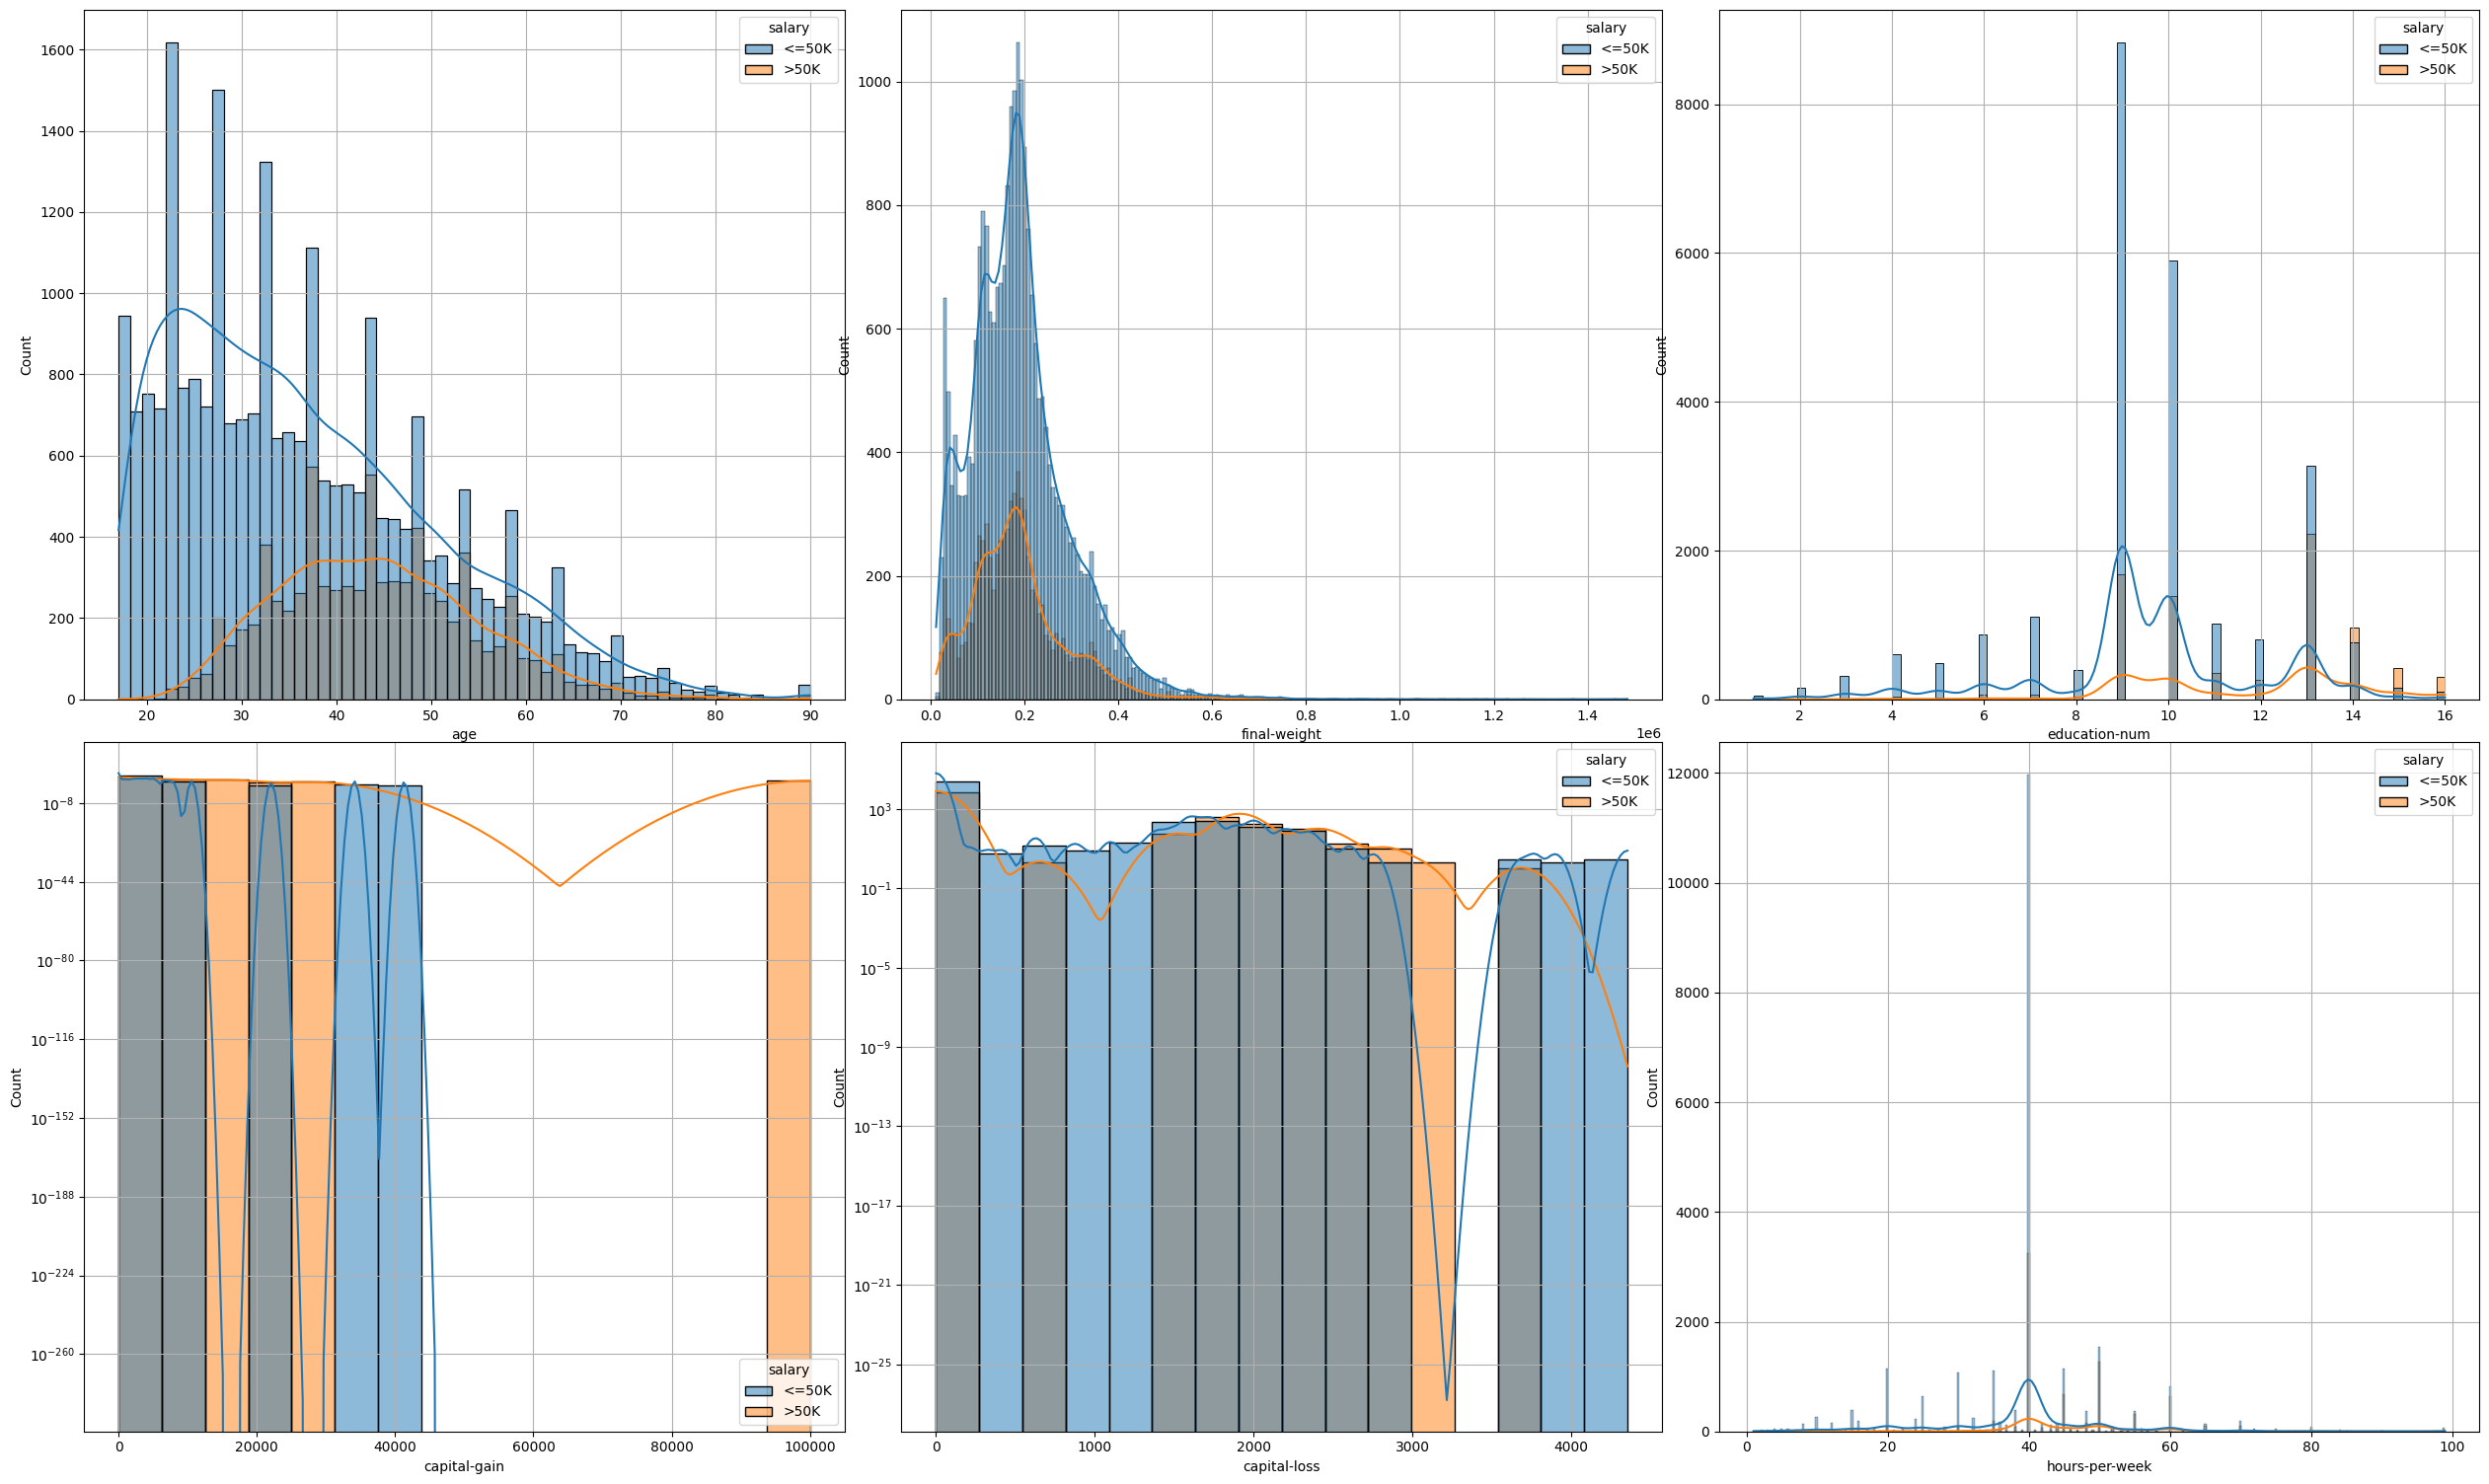

In [319]:
N = len(numerical_var)
K = int(np.ceil(N/2))

fig, axes= plt.subplots(2,K,figsize=(25,15))
fig.tight_layout(h_pad=1)

for n, col in enumerate(numerical_var):
    # print(col)
    i = int(n // K)
    j = int(n % K)
    sns.histplot(data=train_df, x=col, hue="salary", kde=True, stat = "count", ax=axes[i,j])
    axes[i, j].grid()

axes[1,0].semilogy()
axes[1,1].semilogy()


It might be easier to plot the capital gain/loss separately to graps the subbtlilities of the distributions

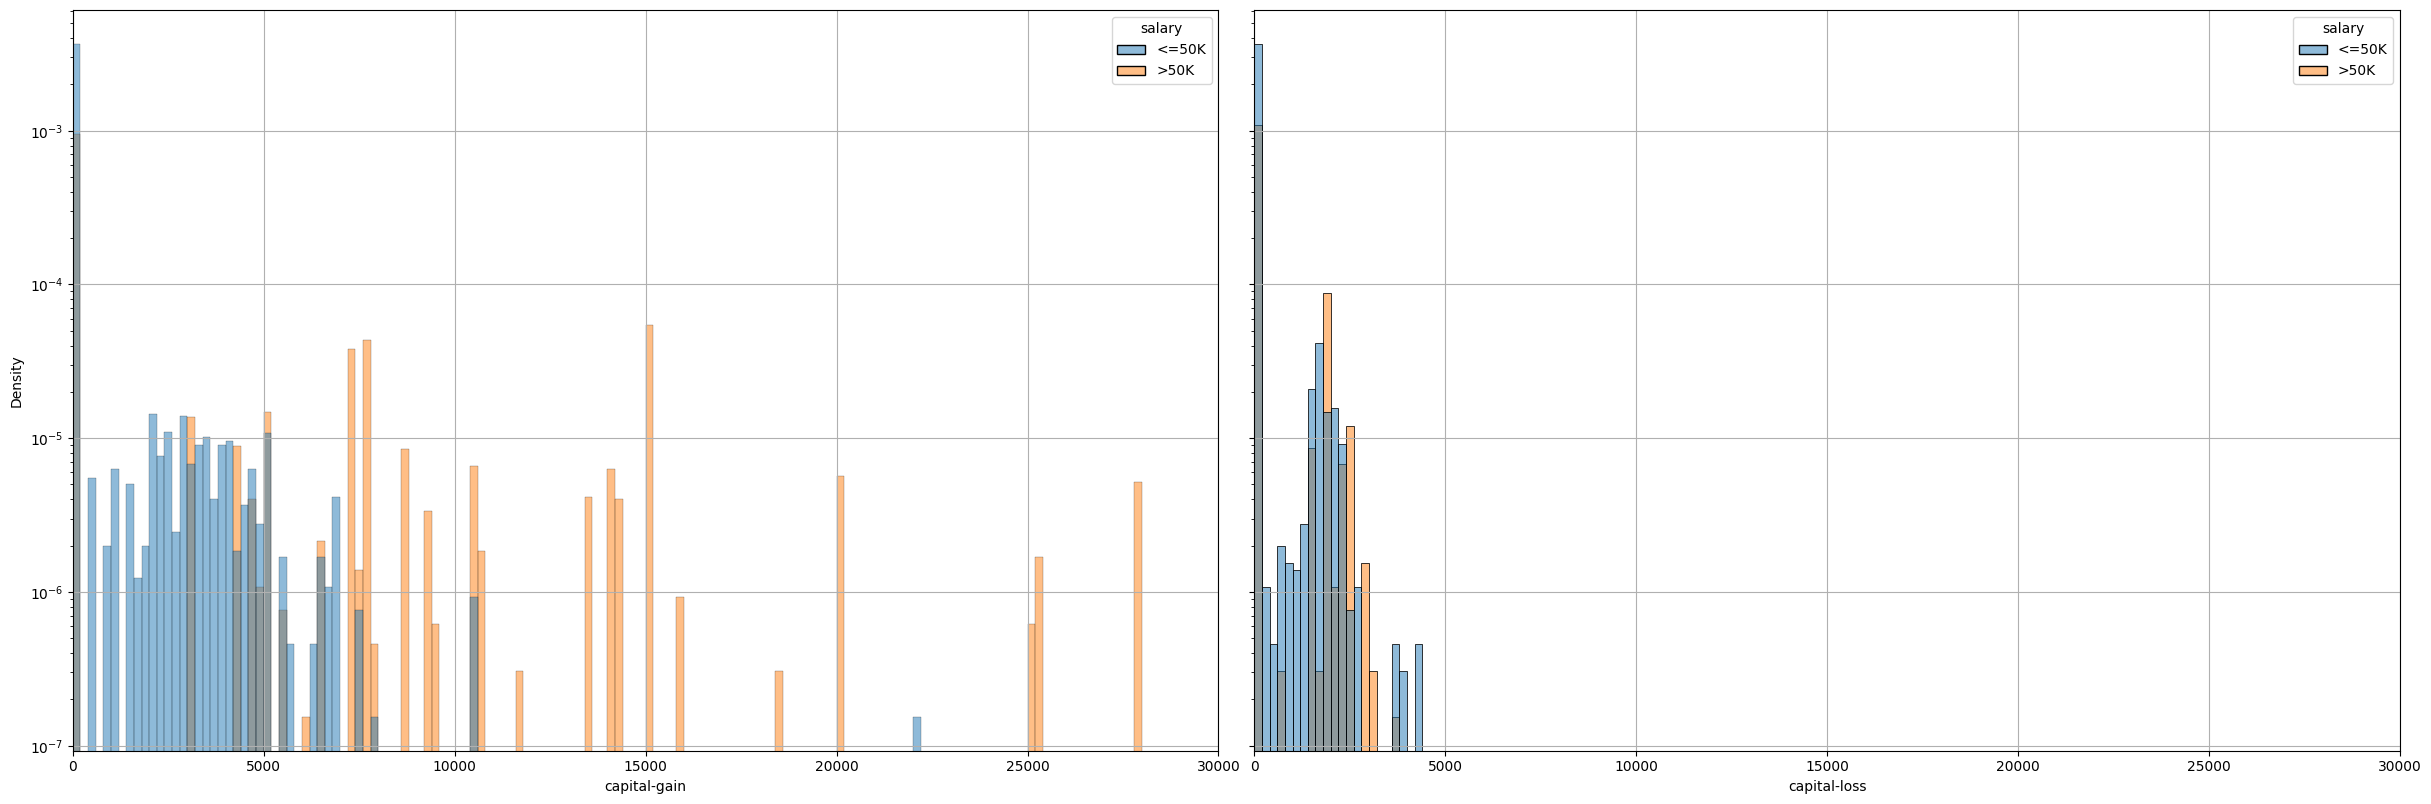

In [320]:
# 'age',  'final-weight', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
fig, axes= plt.subplots(1,2,figsize=(24,8), sharey=True, sharex=True)
fig.tight_layout(w_pad=1)

sns.histplot(data=train_df, x="capital-gain", hue="salary", kde=False, binwidth=200, stat = "density", ax=axes[0]).set(xlim=(0,30000), yscale="log")
axes[0].grid()

sns.histplot(data=train_df, x="capital-loss", hue="salary", kde=False, binwidth=200, stat = "density", ax=axes[1]).grid()


- capital gains for high salaries (>50k) seem to involve higher sums of money whereas for lower salaries (<50k>) it seems to be restricted to small amounts.    
- capital loss are smaller and closer distributed than capital gains. However it seems to affect high and low salaries in a similar way. 

### Some features could be maybe be better represented using a Box-Cox transformation. 

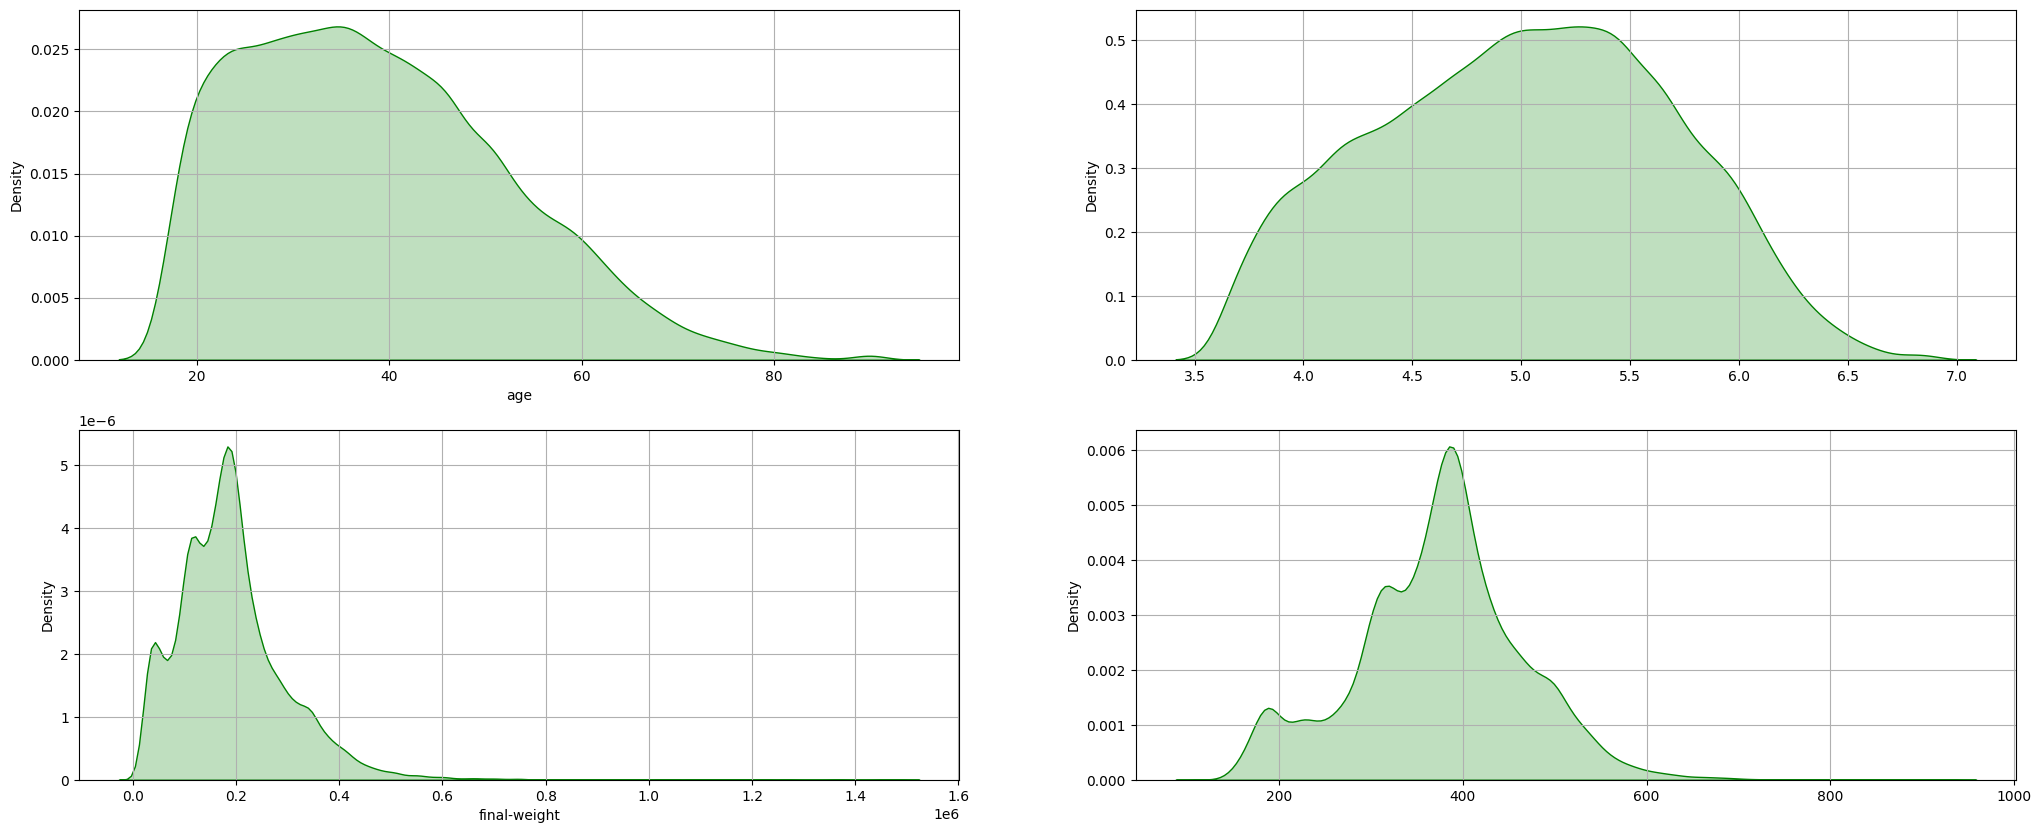

In [321]:
fig, axes = plt.subplots(2,2,figsize=(25,10))

fitted_data_age, fitted_lambda_age = stats.boxcox(train_df["age"])
fitted_data_weight, fitted_lambda_weight = stats.boxcox(train_df["final-weight"])
fitted_data_hours, fitted_lambda_hours = stats.boxcox(train_df["hours-per-week"])

boxcox_df = pd.DataFrame(fitted_data_age, columns=["BoxCox(age)"])
boxcox_df["BoxCox(final-weight)"] = fitted_data_weight
boxcox_df["BoxCox(hours)"] = fitted_data_hours

# sns.distplot(train_df["final-weight"], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, label = "final-weight", color ="green", ax = axes[0]).grid()
# sns.distplot(fitted_data, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, label = "weight after box-cox", color ="green", ax = axes[1]).grid()

sns.kdeplot(train_df["age"], label = "final-weight", color ="green", fill = True, ax = axes[0,0]).grid()
sns.kdeplot(fitted_data_age, label = "weight after box-cox", color ="green", fill = True, ax = axes[0,1]).grid()

sns.kdeplot(train_df["final-weight"], label = "final-weight", color ="green", fill = True, ax = axes[1,0]).grid()
sns.kdeplot(fitted_data_weight, label = "weight after box-cox", color ="green", fill = True, ax = axes[1,1]).grid()


### Some combined features plots might also give us some idea on the correlation between various numerical features

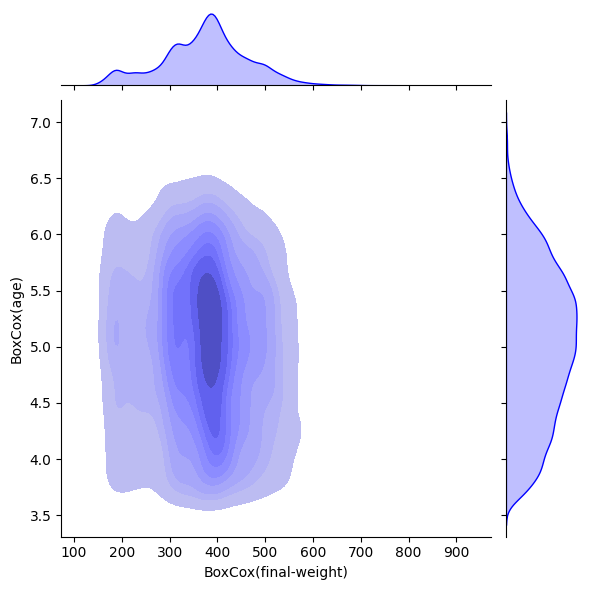

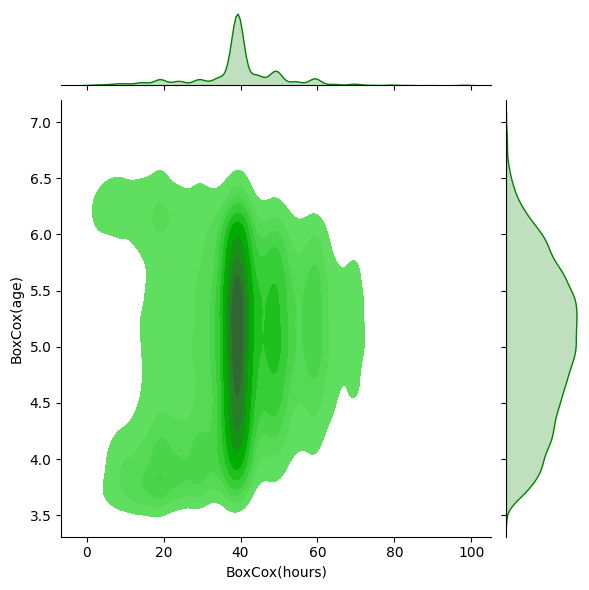

In [322]:
J1 = sns.jointplot(data=boxcox_df, x="BoxCox(final-weight)", y="BoxCox(age)",  kind="kde",  color="b", fill=True)
J2 = sns.jointplot(data=boxcox_df, x="BoxCox(hours)", y ="BoxCox(age)", kind="kde", color="g", fill=True)

## 4.3. Exploring categorical features 

### Check unique values of categorical features 

In [323]:

pd.Series(list(map(set,train_df[categorical_var].values.T)), index=train_df[categorical_var].columns)


workclass         {Local-gov, ?, Self-emp-inc, Self-emp-not-inc, State-gov, Without-pay, Federal-gov, Never-worked, Private}                                                                                                                                                                                                                                                                                                                         
education         {Bachelors, Doctorate, 11th, Some-college, Masters, 7th-8th, Prof-school, 10th, Assoc-voc, 5th-6th, 12th, Preschool, HS-grad, Assoc-acdm, 9th, 1st-4th}                                                                                                                                                                                                                                                                            
marital-status    {Married-spouse-absent, Married-AF-spouse, Widowed, Married-civ-spouse, Never-married, Separated, Divorced

- It looks like some values are unknown (marked with ?). We'll need to replace those with NaNs and maybe use an imputer to fill-in values.   

- Furthermore some categorical features have many values which might reduce the effectiveness of the model so we may want to group some features together to improve the model accuracy (e.g many countries can be grouped against a specific metric like their GDP or development status).  

- Finally some features are semantically very close (e.g separated vs divorced, education vs education) so it would be a good idea to remove redundance

- in particular the categorical feature "education" and numerical feature "education-num" seem similar.. let's try and map them... 

In [324]:
set(list(zip(train_df['education-num'].values, train_df['education'].values)))

{(1, 'Preschool'),
 (2, '1st-4th'),
 (3, '5th-6th'),
 (4, '7th-8th'),
 (5, '9th'),
 (6, '10th'),
 (7, '11th'),
 (8, '12th'),
 (9, 'HS-grad'),
 (10, 'Some-college'),
 (11, 'Assoc-voc'),
 (12, 'Assoc-acdm'),
 (13, 'Bachelors'),
 (14, 'Masters'),
 (15, 'Prof-school'),
 (16, 'Doctorate')}

There is a 1:1 mapping between 'education-num' and 'education', one of them must therefore be removed.
As a design choice, we will remove the numerical feature 'education-num' and group someof the categorical feature in a more meaningful way to try and reduce the number of features to improve the effectiveness of the mode (see grouping further below). 

In [325]:
train_df = train_df.drop('education-num', axis=1)
train_df.columns

Index(['age', 'workclass', 'final-weight', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary'], dtype='object')

### Display proportions of feature values within each categorical variables 

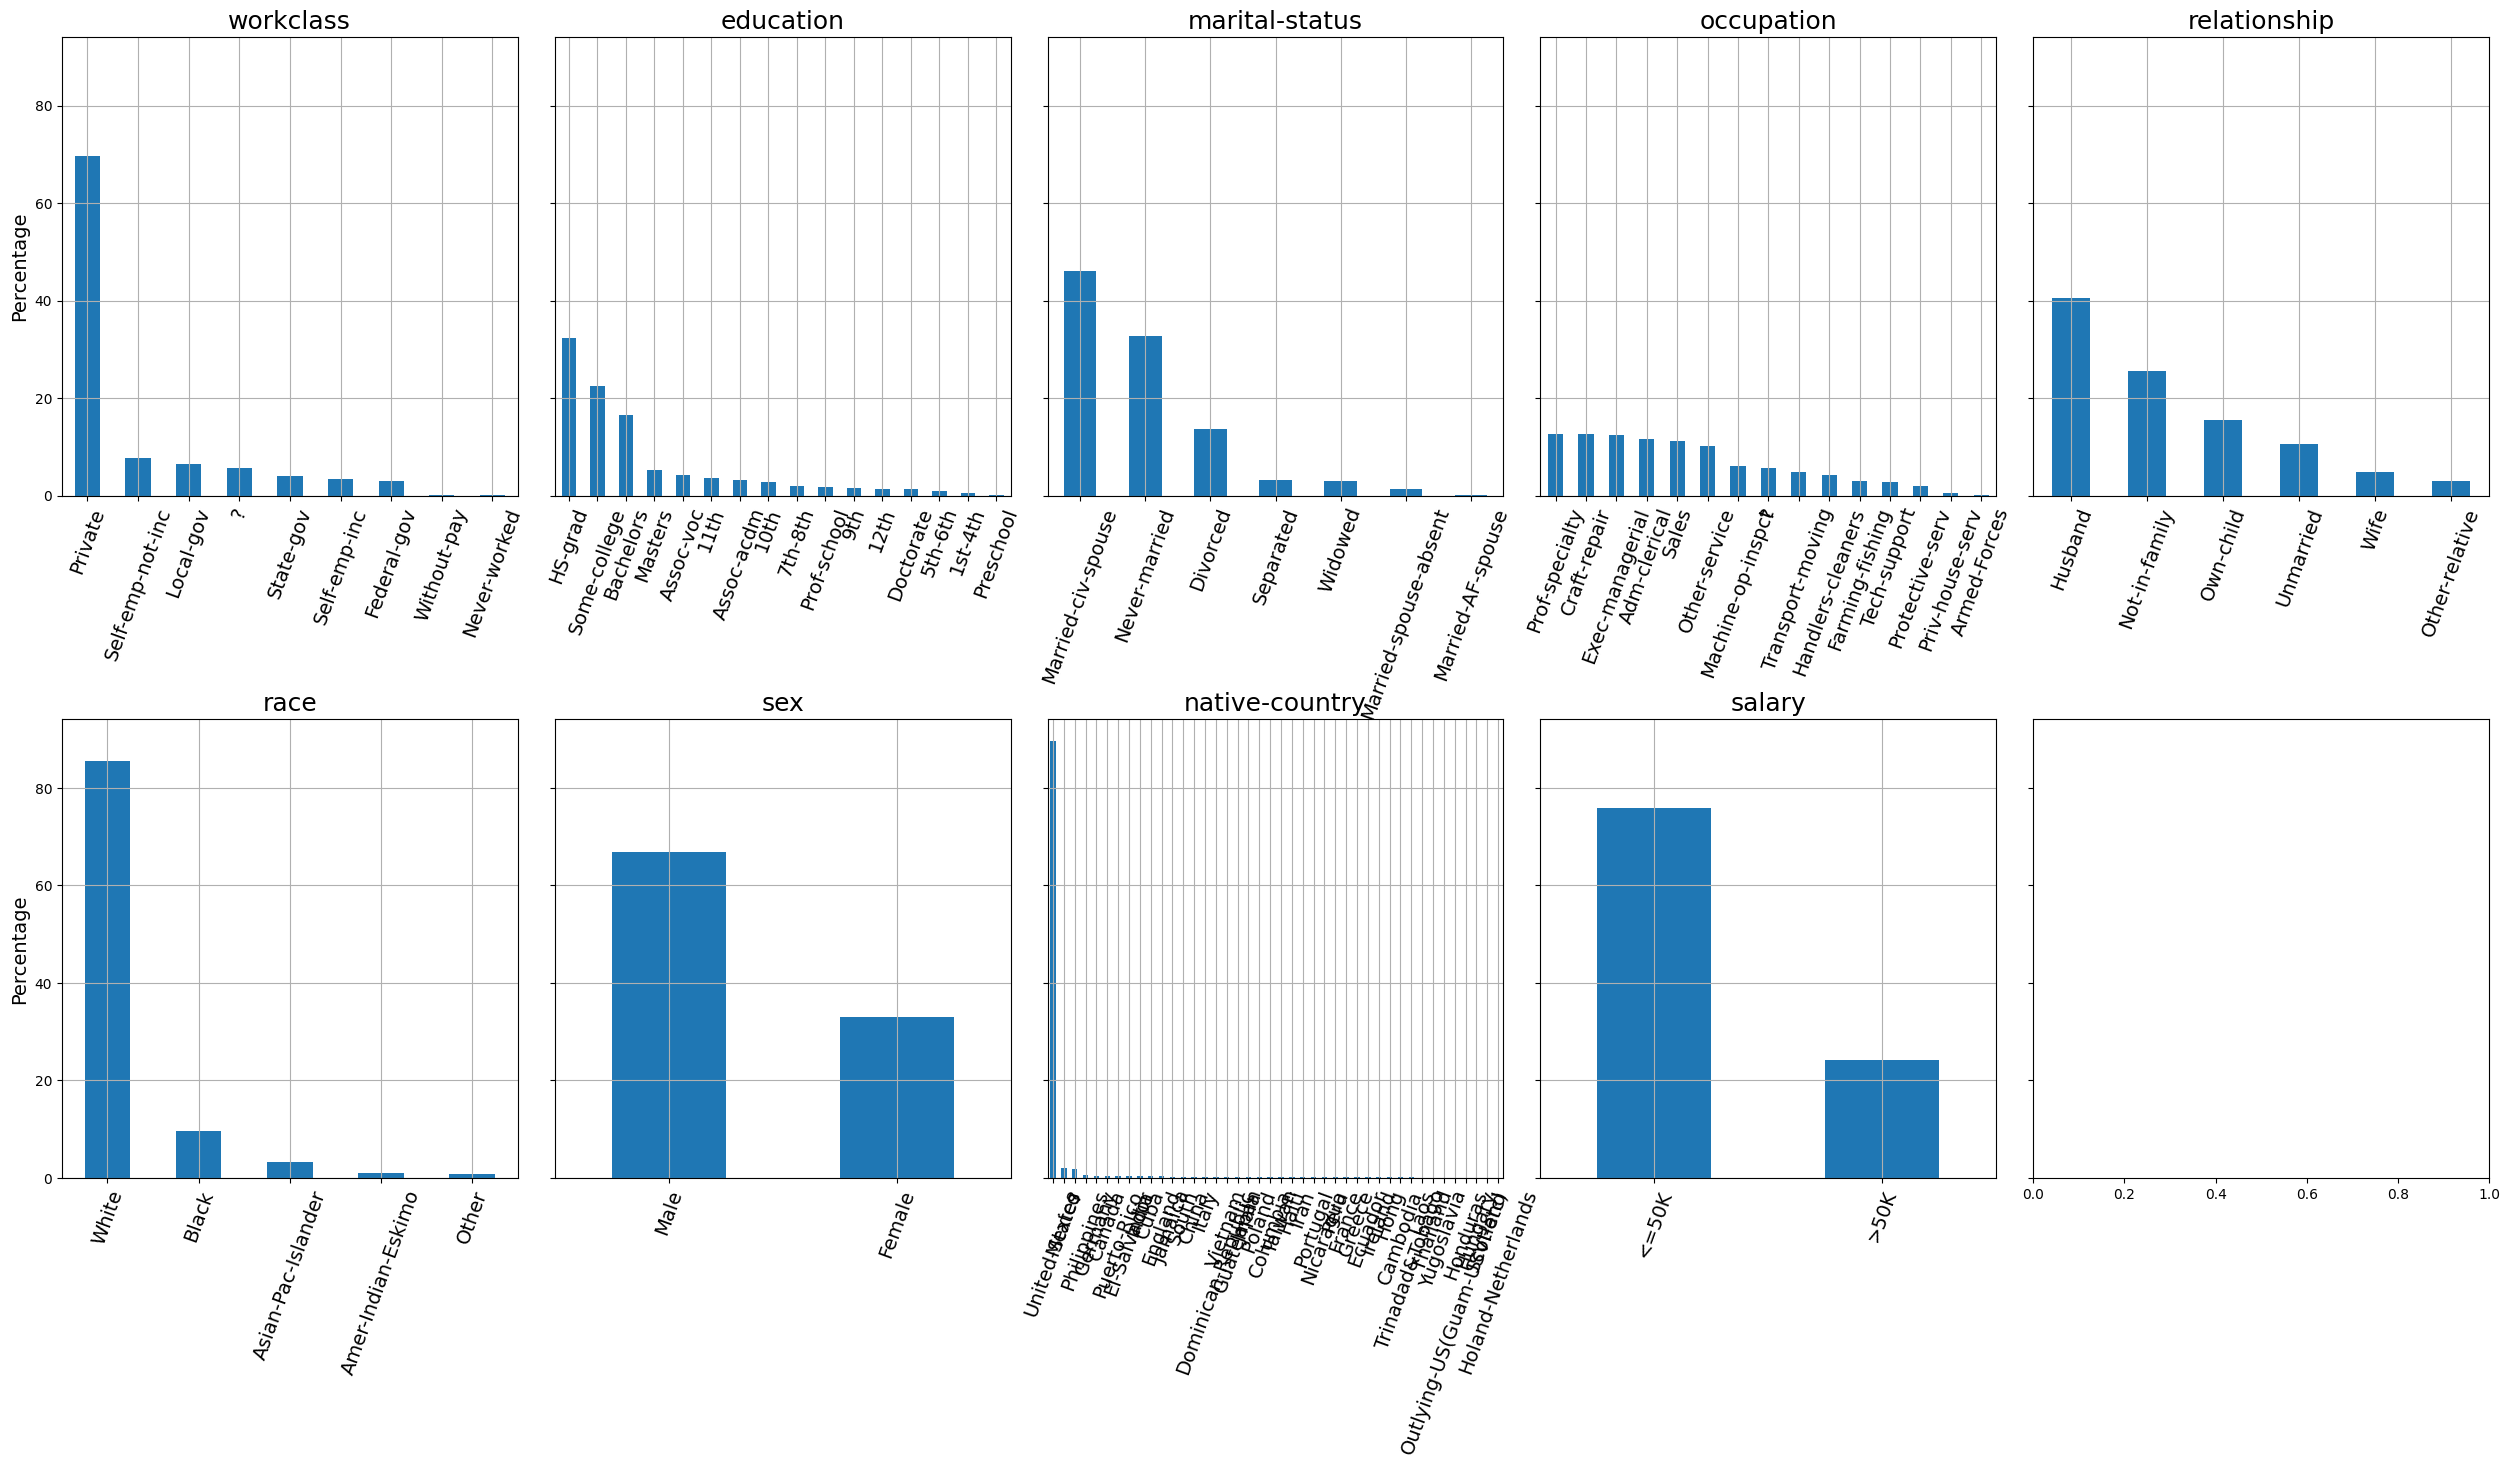

In [326]:
N = len(categorical_var)
K = int(np.ceil(N/2))

fig, axes= plt.subplots(2,K,sharey=True,figsize=(25,12))
fig.tight_layout(h_pad=14)

for n, col in enumerate(categorical_var):
    i = int(n // K)
    j = int(n % K)
    feature_serie = train_df[col].value_counts()
    feature_serie_sum = feature_serie.sum()
    feature_serie_pct = feature_serie / feature_serie_sum * 100
    # print(feature_serie_pct)
    feature_serie_pct.plot.bar(ax=axes[i, j])
    axes[i, j].set_xticklabels(labels=feature_serie_pct.index, rotation=70, size=14)
    axes[i, j].set_title(col, size=18)
    axes[i, j].set_ylabel("Percentage", size=14)
    axes[i, j].grid()

- First to note is the large unbalance (75/25) of the data labels "salary" .
- Then, one could possibly make the following assumptions:
  - The "native country" feature is largely dominated by the US. This is likely due to the fact that data has been collected in the USA and that people originating from other countr...  

### Checking data imbalance for both training and test datasets  

In [327]:
print("Training dataset:\n",round(train_df["salary"].value_counts(normalize=True),2))
print()
print("Testing dataset:\n",round(test_df["salary"].value_counts(normalize=True),2))

Training dataset:
 <=50K    0.76
>50K     0.24
Name: salary, dtype: float64

Testing dataset:
 <=50K    0.76
>50K     0.24
Name: salary, dtype: float64


The training and test sets have the same imbalance level so correcting the imbalance on the training set will provide an adequate prediction on the test set 

### Display proportions of feature values for each label (<=50k vs  >50k) 

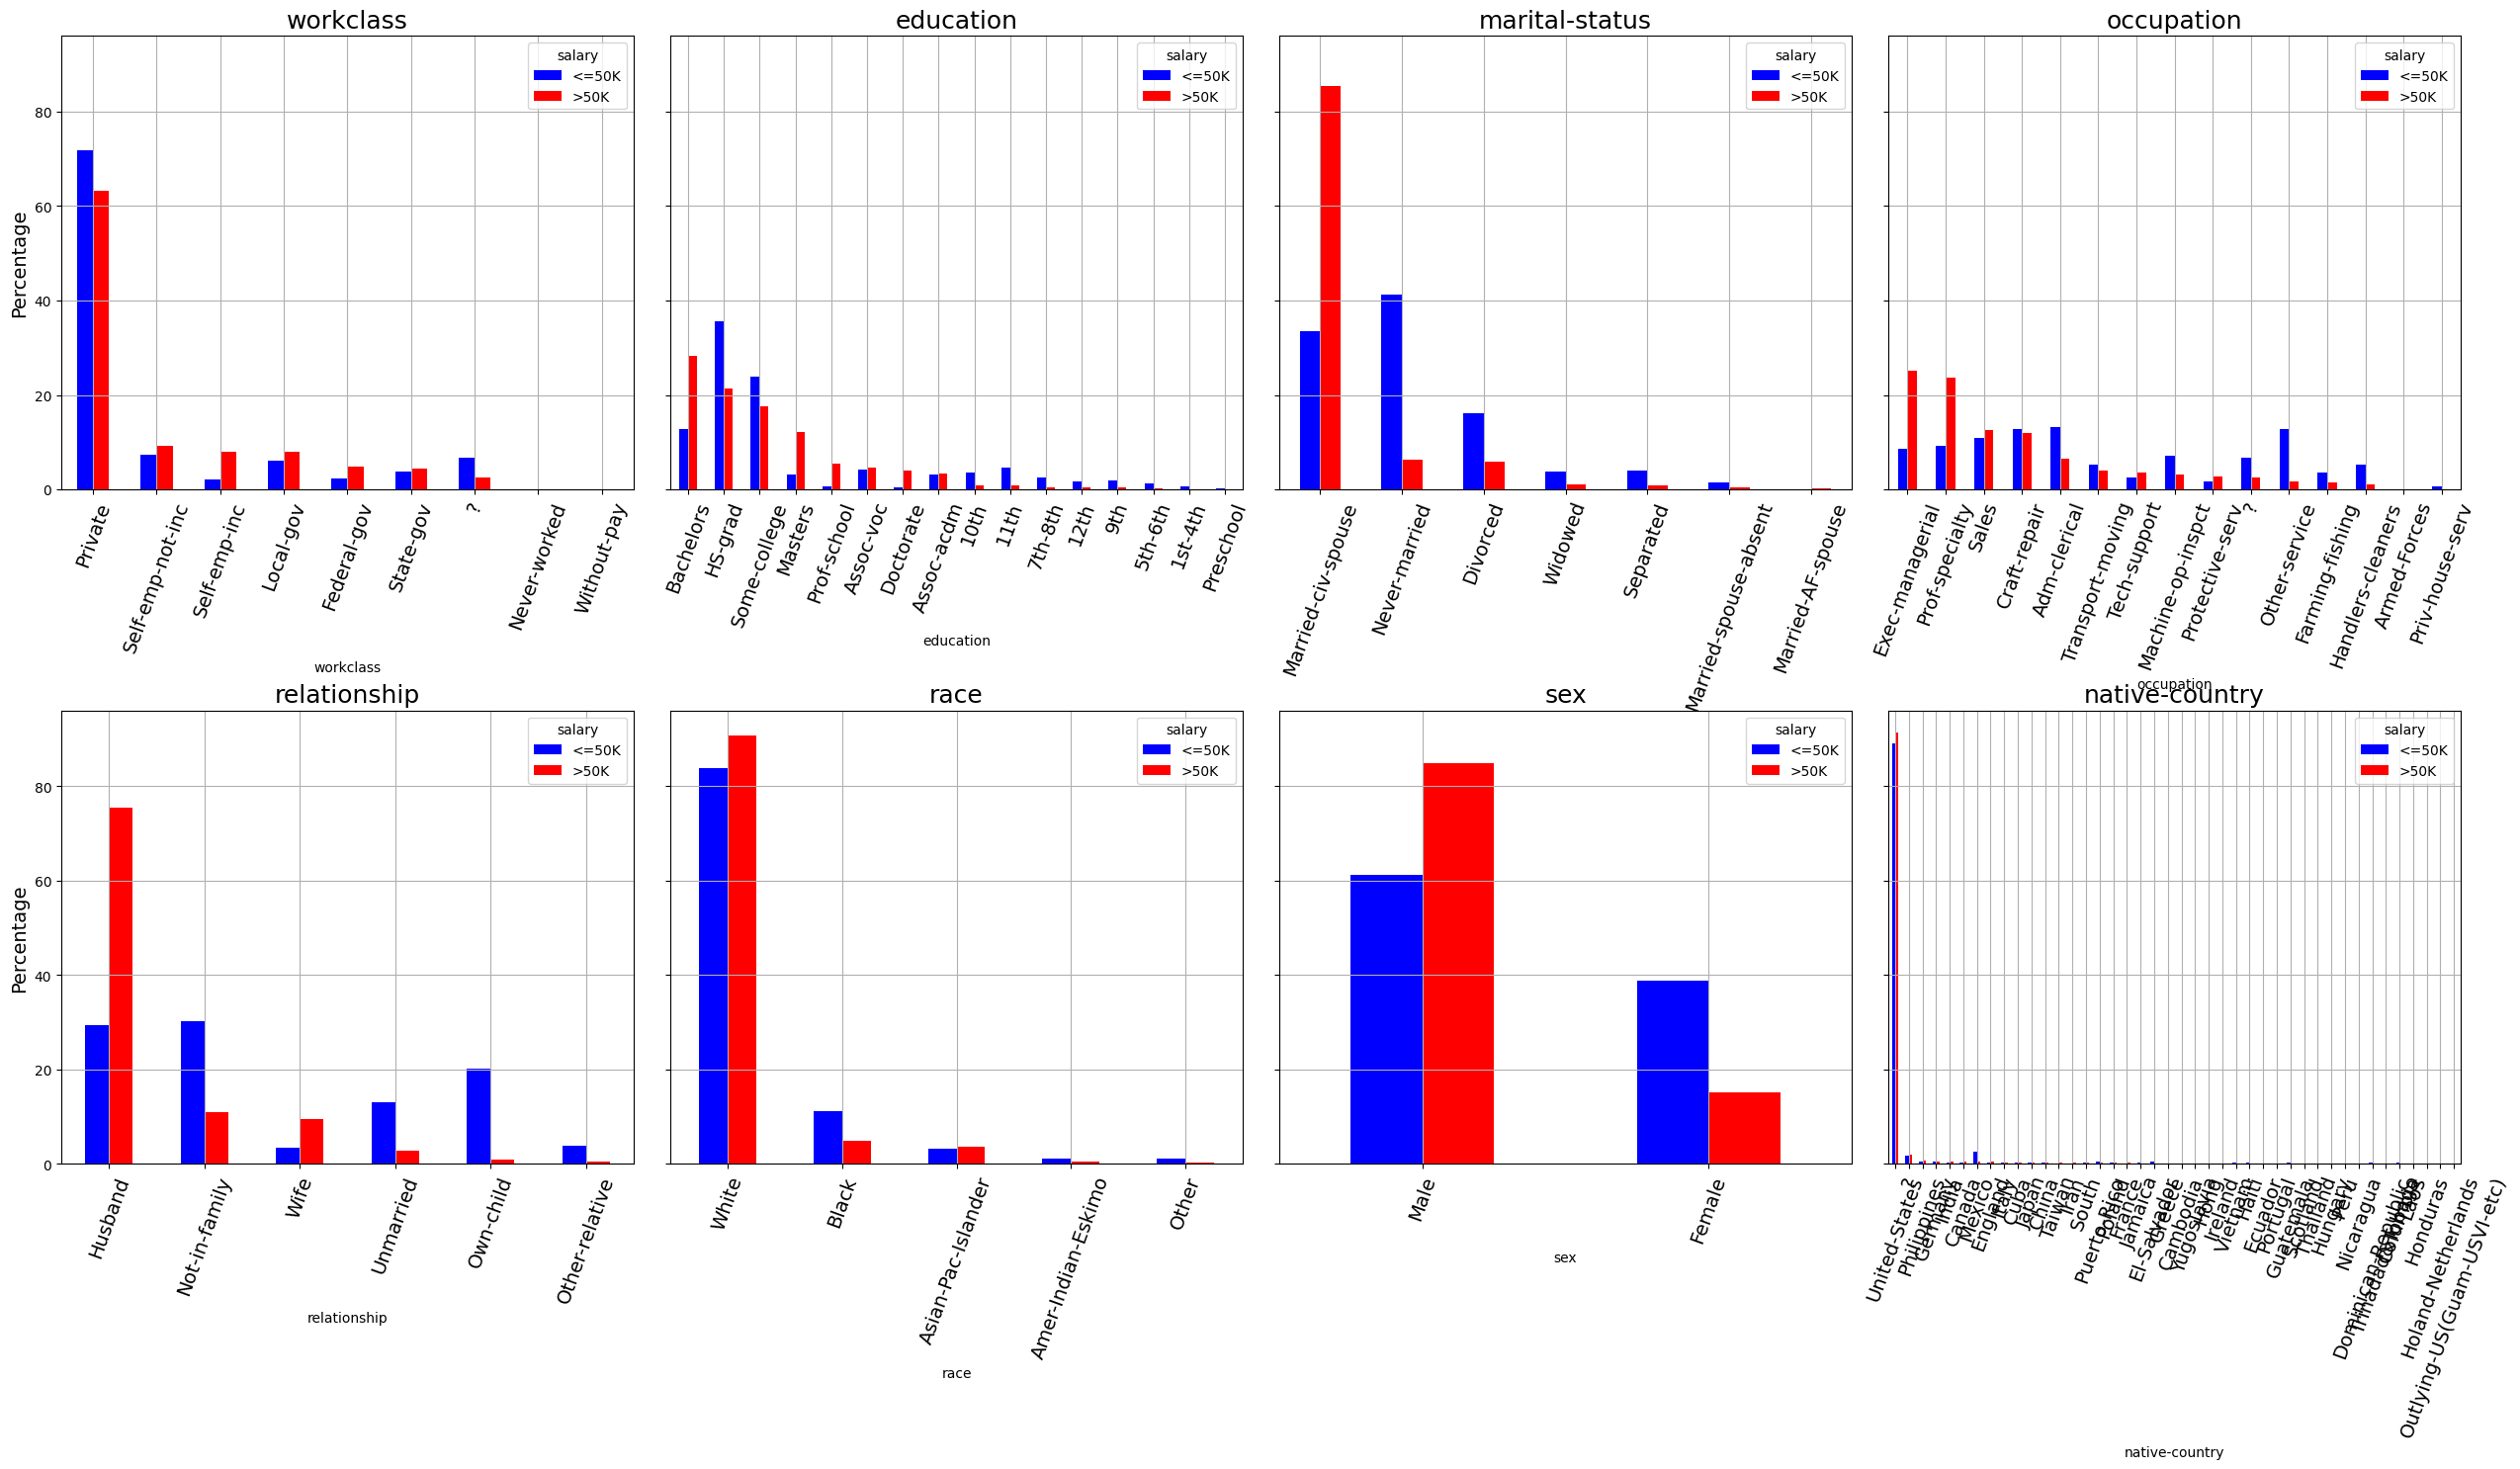

In [328]:
categorical_var_nosalary = categorical_var.copy()
categorical_var_nosalary.remove("salary")

N = len(categorical_var_nosalary)
K = int(np.ceil(N/2))

fig, axes= plt.subplots(2,K,sharey=True,figsize=(25,12))
fig.tight_layout(h_pad=14)

for n, col in enumerate(categorical_var_nosalary):
    i = int(n // K)
    j = int(n % K)

    feature_ratio = pd.crosstab(train_df[col], train_df['salary'])
    feature_ratio_sum = feature_ratio.sum(axis= 0) # Use this to account for the unbalance dataset (pct considering each label independently)
    # feature_ratio_sum = train_df[col].value_counts().sum() # Use this to get the absolute proportion of feature values (biased towards <=50k due to unbalanced dataset)  
    feature_ratio_pct = feature_ratio / feature_ratio_sum * 100
    feature_ratio_pct_sorted = feature_ratio_pct.sort_values('>50K', ascending=[False])
    # print(feature_ratio_pct_sorted)
    
    feature_ratio_pct_sorted.plot.bar(ax=axes[i, j], color=["blue", "red"])
    axes[i, j].set_xticklabels(labels=feature_ratio_pct_sorted.index, rotation=70, size=14)
    axes[i, j].set_title(col, size=18)
    axes[i, j].set_ylabel("Percentage", size=14)
    axes[i, j].grid()


The above plot shows the proportion of each feature values for each label class (">50k" vs "<50k") i.e add all blue bars (respectively red) to reach 100%.  
The data has been non-dimensionalized across the labels.   

We now would like to show the proportion of each label for each feature value i.e do the non-dimensionalization of data using feature values counts.  

### Display proportion of each label per categorical feature values

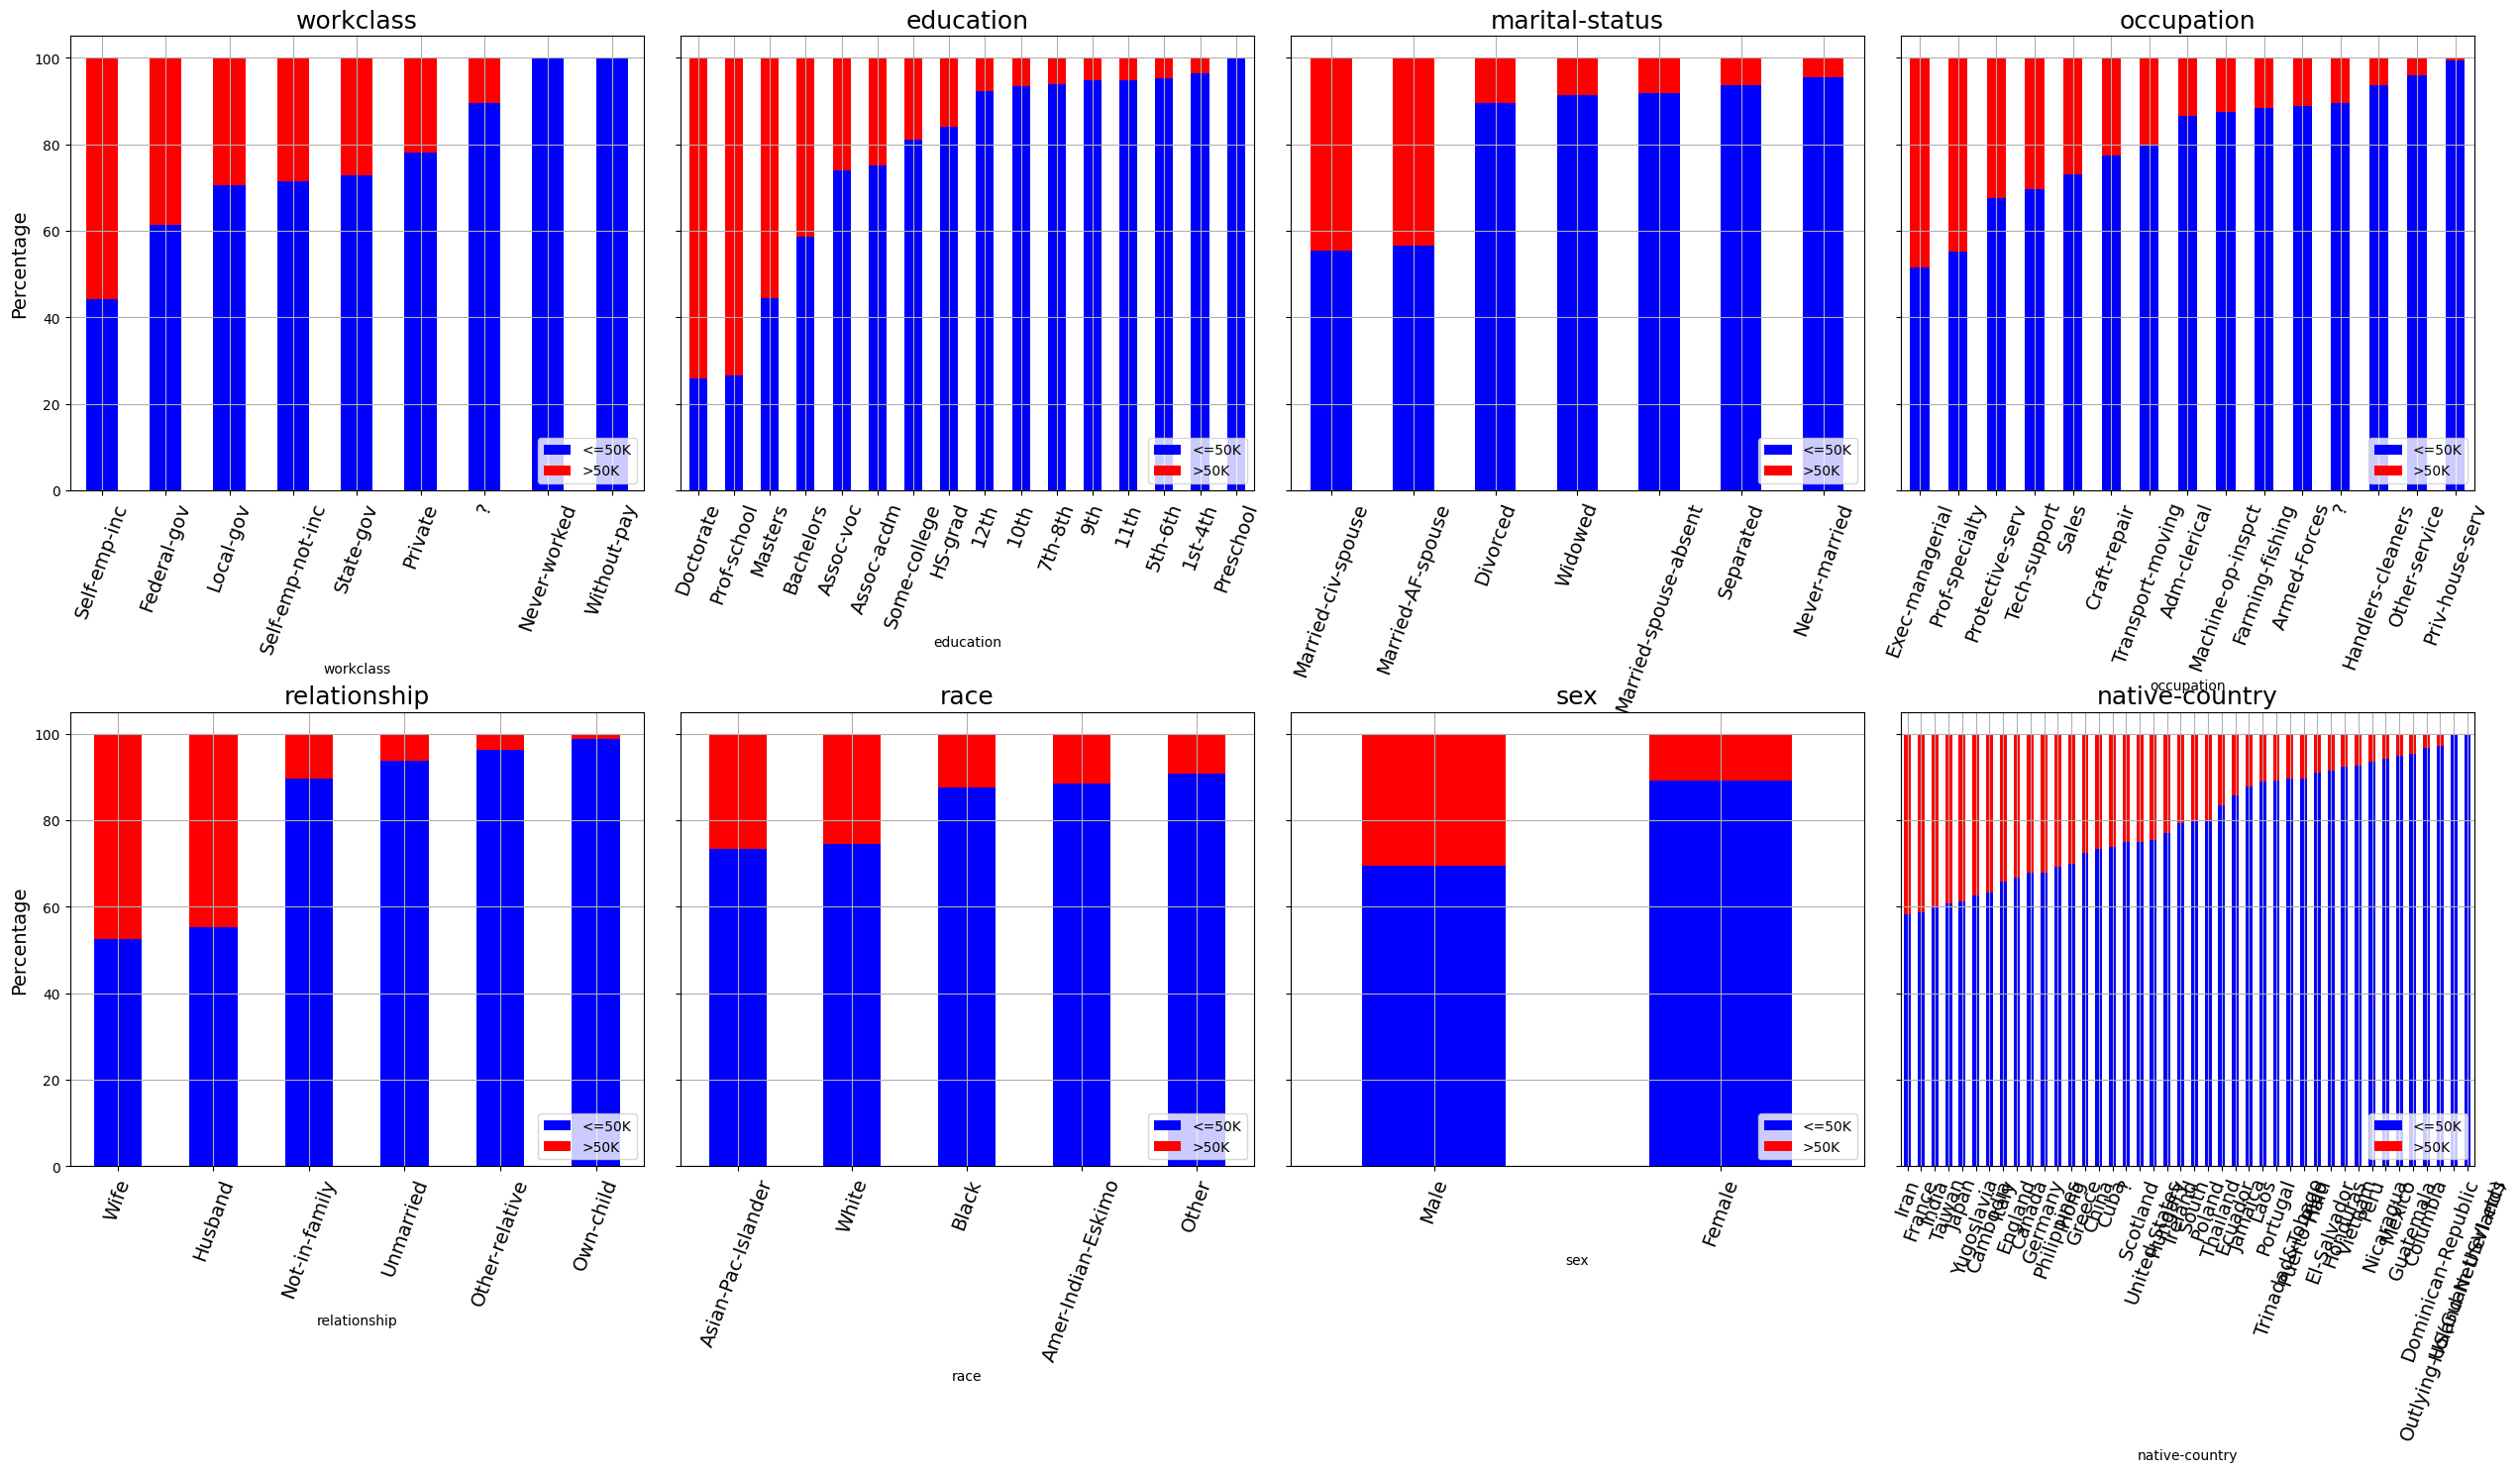

In [329]:
fig, axes= plt.subplots(2,K,sharey=True,figsize=(25,12))
fig.tight_layout(h_pad=14)

for n, col in enumerate(categorical_var_nosalary):
    i = int(n // K)
    j = int(n % K)

    feature_ratio = pd.crosstab(train_df[col], train_df['salary'])
    feature_ratio_sum = feature_ratio.sum(axis= 1) # NOW THE SUMMING IS DONE COLUMNS WISE
    feature_ratio_pct = (feature_ratio.T / feature_ratio_sum).T * 100
    feature_ratio_pct_sorted = feature_ratio_pct.sort_values('>50K', ascending=[False])
    # print(feature_ratio_pct_sorted)
    
    feature_ratio_pct_sorted.plot.bar(ax=axes[i, j], stacked = True, color=["blue", "red"])
    axes[i, j].set_xticklabels(labels=feature_ratio_pct_sorted.index, rotation=70, size=14)
    axes[i, j].set_title(col, size=18)
    axes[i, j].set_ylabel("Percentage", size=14)
    axes[i, j].legend(loc='lower right')
    axes[i, j].grid()


Some interesting trends can be observed:
- some feaure values seem to have the same proportion related to high and low salaries. It may be usefull to group them.
- As expected the higher the education, the higher the proportion of high earners.
- Similarly self-employed people seem to have a higher proprtion of high earners. 
- the proportion of Males earning high salaries is  3 times higher than the proportion of Female high earners (even though the Gender population is roughly 50/50)
- Similarly the proportion high earners is larger for White ethnicity vs other. An interesting fact is that Islanders have a similar high/low earner distribution than White ethnicity. 
- Interestingly the proportion of high earners of some native countries is fairly counter intuitive. However this can be easily explained by the fact that this is a US survey data and that people from foreign native country have been able to emigrate to the USA either due to their wealth or the education level. So the data is basically biased.

### Data features correlation

Evaluating correlation matrix...


salary: 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


done.


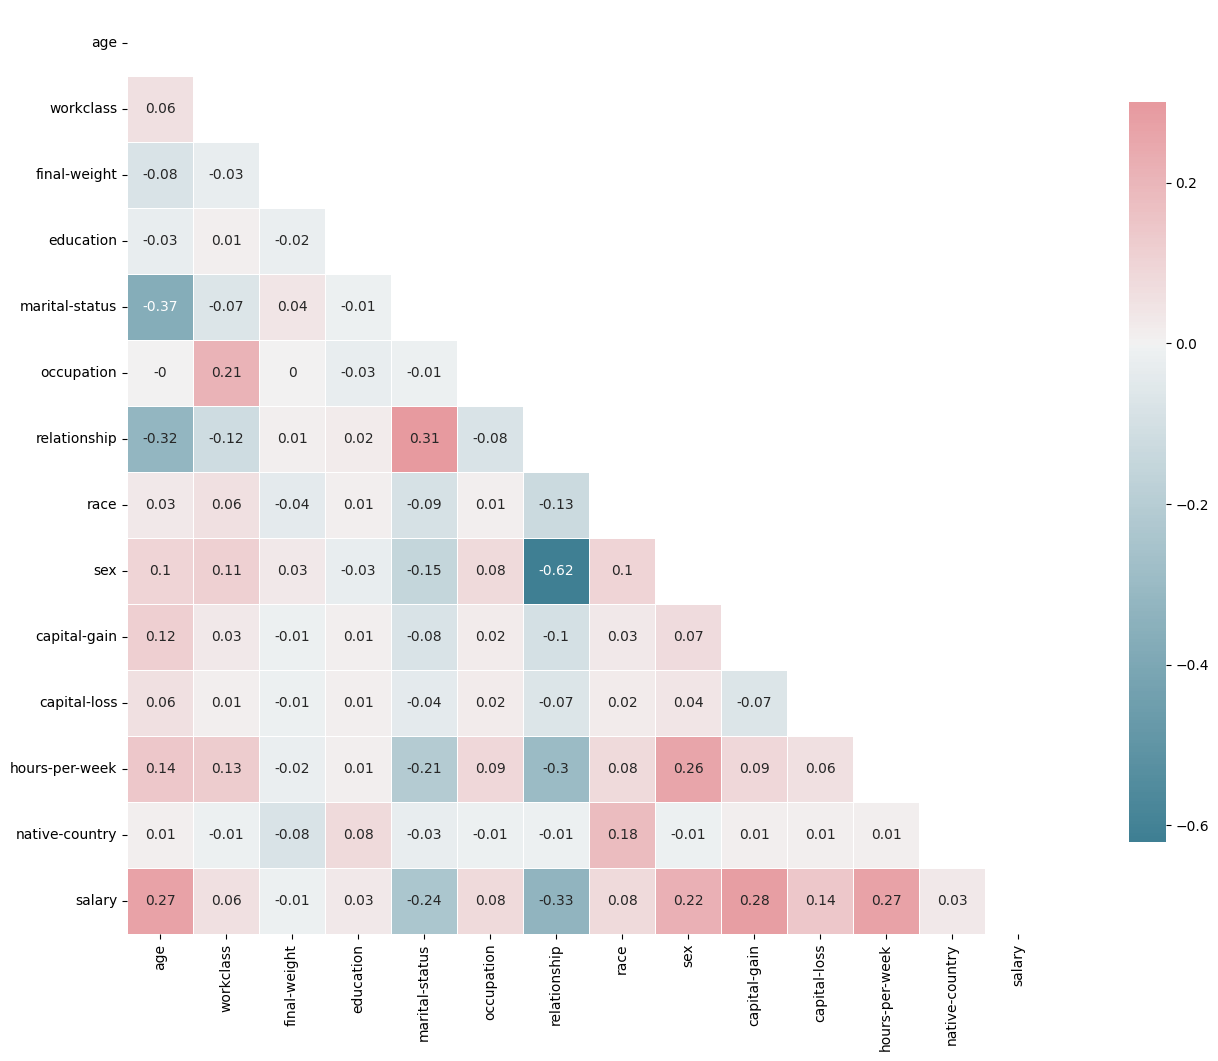

In [330]:
# Evaluation correlations
corr_matrix = evaluate_correlation(train_df)

# Generate a correlation matrix heat map
plot_correlation(corr_matrix)

Some interesting trends can be observed:   
- "age", "sex", "capital-gain", "capital-loss"  and "hours-per-week" have a HIGH POSITIVE correlation to "salary" 
== whereas == 
- "marital-status", "relationship" have a HIGH NEGATIVE correlation to "salary". 

- On the contrary "workclass", "final-weight", "education(cat)", "occupation", "race", and "native-country" seem to have a very LOW correlation to "salary".   

- Note that "final-weight" is unlikely to be a real feature (i.e obtained in a real world scenario) so will not be used in the model. 

- Some interesting correlations between features to note:
   - "sex" and "hrs_per_week"
   - "sex" and "relationship"
   - "sex" and "marital-status" 
   - "race" and "native-country"
   - "age" and "relationship"
   - "workclass" and "occupation"

Let's investigate further... 

In [331]:
train_df = train_df.drop('final-weight', axis=1)
train_df.columns

Index(['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary'], dtype='object')

# 5. Data imbalance, data cleaning & feature engineering

The purpose of that section is to tackle the potential problems that may occur as a result of issues observed in the data exploration.

This should include:
- Data imbalance
- Data cleaning, replacing "?" values with the string "unknown" for instance 
- Feature selection and grouping if required
- Data transformation (encoding of categorical features, normalization of numerical features)
- Removal of redundant features

To be able to apply the same transformation to the test set we will use PIPELINE and COLUMNTRANSFORMER for all data transformation.

## 5.1 Redundant features removal

- For info, the numerical feature "eduction-num" has already been removed as it was redundant with the categorical feature "education".

- Similarly the numerical feature "final-weight" was deemed as not realistic (but rather an aggregated score from other features) and was also removed from the training dataset.

In [332]:
test_df = test_df.drop('education-num', axis=1)
test_df = test_df.drop('final-weight', axis=1)

## 5.2 Imbalanced data

The data imbalance can be addressed using either SMOTE or OVERSAMPLING methods.   
**Warning**: this is only done on the training dataset.

The paragrpah below is a short investigation of the imbalance methods available at the time of writing.   
**Warning**: the selected method will be implmented in the pipeline directly

In [59]:
print("Data imbalance before correction: \n",np.round(pd.DataFrame(train_df["salary"].value_counts(normalize=True)*100),1) )

# METHOD 1: SMOTE
categorical_feature_mask = train_df.drop("salary", axis=1).dtypes == object
smote = SMOTENC (categorical_features = categorical_feature_mask, sampling_strategy="minority")
X_balanced_df, y_balanced_df = smote.fit_resample(train_df.copy().drop("salary", axis=1), train_df["salary"])

# METHOD 2: OVER-SAMPLING
# ROS = RandomOverSampler() # random_state=30
# ROS.fit(train_df.copy().drop("salary", axis=1), train_df["salary"])
# X_balanced_df, y_balanced_df = ROS.fit_resample(train_df.copy().drop("salary", axis=1), train_df["salary"])

# METHOD 3: SVM-SMOTE
# X_balanced_df, y_balanced_df = SVMSMOTE(sampling_strategy=0.1).fit_resample(train_df.copy().drop("salary", axis=1), train_df["salary"])

# METHOD 4: BorderlineSMOTE
# X_balanced_df, y_balanced_df = BorderlineSMOTE(sampling_strategy=0.1).fit_resample(train_df.copy().drop("salary", axis=1), train_df["salary"])

# METHOD 5: ADASYN
# X_balanced_df, y_balanced_df = ADASYN(sampling_strategy=0.1).fit_resample(train_df.copy().drop("salary", axis=1), train_df["salary"])

# METHOD 6: Minority class weights
# train_df.set_params(is_unbalance = True)
# scale_pos_weight = np.round(pd.DataFrame(train_df["salary"])).value_counts()[0] / np.round(pd.DataFrame(train_df["salary"])).value_counts()[1]



# Check dataset imbalance
print()
print("Data imbalance after correction: \n",np.round(y_balanced_df.value_counts(normalize=True)*100, 1))


Data imbalance before correction: 
        salary
<=50K  75.9  
>50K   24.1  



Data imbalance after correction: 
 <=50K    50.0
>50K     50.0
Name: salary, dtype: float64


## 5.3 Data transformation overview

### Feature engineering

From the data exploration section, we noticed that (1) categorical features included a lot of sub-features (aka feature values) which would contribute,if all considered separately, to lower the effectiveness of the model and (2) that many of those feature values had similar or close semantic meanings.   

It therefore does make sense to try and group some of those feature values into new categorical features to reduce the overall number of categorical feature values and improve the effectiveness of the model algorithm.   

Further, for practical reasons, we want to PIPELINE all transformations to be able to (1) modify the transform in a flexible manner if we have to and  (2) apply the same set of transformations to both the training and test sets.    

The grouping strategy is explained here:   
- Basically, for each categorical features, a bunch of features are grouped together.     
- The grouped categorical features are then stored in dictionnary with (1) the group name as key and (2) the list of feature values to be grouped as values.   
- A customer transformer will automatically apply the grouping (see GroupFeatureValues_CT in Helper function section).   
 

In [333]:
CAT_FEATS_GROUP = {}

###  education: 
# { Preschool, 1st-4th,  5th-6th, 7th-8th,  9th, 10th, 11th, 12th, HS-grad, Assoc-voc, Some-college, Bachelors,  Masters,  Prof-school, Assoc-acdm, Doctorate} 
elem_school = ['Preschool', '1st-4th','5th-6th']
mid_school = ['7th-8th' ]
high_school_lower = ['9th','10th','11th','12th']
high_school_upper = ['HS-grad', 'Assoc-voc', 'Assoc-acdm', 'Some-college',]
graduate = ['Bachelors', 'Masters']
post_grad = ['Prof-school', 'Doctorate']
CAT_FEATS_GROUP["education"] = {"elem_school":elem_school, "mid_school":mid_school, "high_school_lower":high_school_lower, "high_school_upper":high_school_upper, 
                  "graduate":graduate, "post_grad":post_grad}
education_rank = [["elem_school", "mid_school", "high_school_lower", "high_school_upper", "graduate", "post_grad"]]


##  workclass: 
# {nan, Self-emp-not-inc, Local-gov, Federal-gov, Self-emp-inc, Without-pay, Private, State-gov, Never-worked}                                                                                                                                                                                                                                                                                                                         
self_employed_expert = ['Self-emp-inc']
self_employed = ['Self-emp-not-inc', "Private"]
public_servant = ['Local-gov','State-gov','Federal-gov']
unemployed = ["Without-pay", "Never-worked"]
CAT_FEATS_GROUP["workclass"] = {"self_employed_expert":self_employed_expert,"self_employed":self_employed, "public_servant":public_servant, "unemployed":unemployed}


### occupation: 
# {nan, Sales, Farming-fishing, Machine-op-inspct, Craft-repair, Transport-moving, Protective-serv, Priv-house-serv, Other-service, Prof-specialty, Exec-managerial, 
#  Armed-Forces, Handlers-cleaners, Adm-clerical, Tech-support}
executives = ["Prof-specialty", "Exec-managerial"]
experts = ["Protective-serv", "Tech-support", "Sales", "Craft-repair", "Transport-moving"]
technicians = ["Adm-clerical", "Machine-op-inspct", "Farming-fishing", "Armed-Forces"]
services = ["Priv-house-serv", "Other-service", "Handlers-cleaners"]
CAT_FEATS_GROUP["occupation"] =  {"executives":executives, "experts":experts, "technicians":technicians, "services":services}


### marital-status: 
# {Widowed, Married-civ-spouse, Married-spouse-absent, Divorced, Separated, Married-AF-spouse, Never-married}          
couple = ['Married-civ-spouse','Married-AF-spouse']
single = ['Separated','Divorced', 'Married-spouse-absent', 'Widowed', 'Never-married']
CAT_FEATS_GROUP["marital-status"] =  {"couple":couple, "single":single}


### relationship: 
# {Unmarried, Not-in-family, Wife, Other-relative, Husband, Own-child}  
family_strong = ["Wife", "Husband"]
family_weak = ["Other-relative", "Own-child"]
family_none = ["Unmarried", "Not-in-family"] 
CAT_FEATS_GROUP["relationship"] =  {"family_strong":family_strong, "family_weak":family_weak, "family_none":family_none}


## native-country
# GDP info: https://statisticstimes.com/economy/countries-by-projected-gdp-capita.php

# countries with GDP/capita >40kUSD
GDP_high = ["France",  "Ireland",  "United-States",  "Holand-Netherlands",  "Canada",  "Germany",  "Hong",  "England",  "Japan",  "Scotland"] 
# countries with GDP/capita <20kUSD
GDP_mid  = ["Italy",  "South",  "Puerto-Rico",  "Taiwan",  "Portugal", "Greece", "Hungary", "Poland", "Trinadad&Tobago", "China"]
# countries with GDP/capita <10kUSD
GDP_low = ["Mexico", "Dominican-Republic", "Thailand", "Peru", "Columbia", "Ecuador", "Jamaica", "Guatemala", "El-Salvador", "Vietnam", "Philippines", "Laos", "Honduras", "India", 
           "Nicaragua", "Haiti", "Cambodia", "Iran", "Yugoslavia", "Outlying-US(Guam-USVI-etc)", "Cuba"] 
CAT_FEATS_GROUP["native-country"] =  {"GDP_high":GDP_high, "GDP_mid":GDP_mid, "GDP_low":GDP_low}


#### Overview
print("NEW grouped categorical features: ")
for key in CAT_FEATS_GROUP.keys():
    print(key.upper())
    # print(CAT_FEATS_GROUP[key])
    for key2, value in CAT_FEATS_GROUP[key].items():
        print(key2, ' : ', value)
    print()


NEW grouped categorical features: 
EDUCATION
elem_school  :  ['Preschool', '1st-4th', '5th-6th']
mid_school  :  ['7th-8th']
high_school_lower  :  ['9th', '10th', '11th', '12th']
high_school_upper  :  ['HS-grad', 'Assoc-voc', 'Assoc-acdm', 'Some-college']
graduate  :  ['Bachelors', 'Masters']
post_grad  :  ['Prof-school', 'Doctorate']

WORKCLASS
self_employed_expert  :  ['Self-emp-inc']
self_employed  :  ['Self-emp-not-inc', 'Private']
public_servant  :  ['Local-gov', 'State-gov', 'Federal-gov']
unemployed  :  ['Without-pay', 'Never-worked']

OCCUPATION
executives  :  ['Prof-specialty', 'Exec-managerial']
experts  :  ['Protective-serv', 'Tech-support', 'Sales', 'Craft-repair', 'Transport-moving']
technicians  :  ['Adm-clerical', 'Machine-op-inspct', 'Farming-fishing', 'Armed-Forces']
services  :  ['Priv-house-serv', 'Other-service', 'Handlers-cleaners']

MARITAL-STATUS
couple  :  ['Married-civ-spouse', 'Married-AF-spouse']
single  :  ['Separated', 'Divorced', 'Married-spouse-absent', 'W

## 5.4 Data transformation using customer transformers 


### Data transformation illustrated in detail for each categorical Feature value  

Different feature variables require different transformations, even within the set of categorical variables.  

In order to make the data transformation easier to understand each transformation is explained separately in the sections below using Custom Transformers to output pandas DataFrame. 


### Ordinal categorical features

This pipeline of custom transformer takes the re-engineered (grouped) features values from the categorial feature "education" and encode them via an ordinal encoder 

In [117]:
VERBOSE = True


CAT_FEATS_ORDINAL = ["education"]
CAT_FEATS_ORDINAL_DICT = [{feature:CAT_FEATS_GROUP[feature]} for feature in CAT_FEATS_ORDINAL]

pipe1 = Pipeline(steps=[('extract', ColumnExtractor_CT(CAT_FEATS_ORDINAL)),
                        ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                        ('group feature values', GroupFeatureValues_CT(CAT_FEATS_ORDINAL_DICT)),
                        ('Ordinal encoding', OrdinalEncoder_CT(categories=education_rank)),
                        ], verbose=VERBOSE)

df1 = pipe1.fit_transform(train_df)
df1.head()

[Pipeline] ........... (step 1 of 4) Processing extract, total=   0.0s
[Pipeline] ......... (step 2 of 4) Processing Replace ?, total=   0.0s
[Pipeline]  (step 3 of 4) Processing group feature values, total=   0.0s
[Pipeline] .. (step 4 of 4) Processing Ordinal encoding, total=   0.0s


,education
0,4.0
1,4.0
2,3.0
3,2.0
4,4.0


### One Hot Encoded features

This pipeline of custom transformers takes the re-engineered (grouped) features values from various categorial features and encode them via an OHE  encoder. Note that the origin of the feature value is still availble through the feature name.

In [72]:
CAT_FEATS_OHE = ['workclass', 'marital-status', 'occupation', 'relationship', 'native-country']
CAT_FEATS_OHE_DICT = [{feature:CAT_FEATS_GROUP[feature]} for feature in CAT_FEATS_OHE]

pipe2 = Pipeline(steps=[('columns extraction', ColumnExtractor_CT(CAT_FEATS_OHE)),
                        ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                        ('feature values grouping', GroupFeatureValues_CT(CAT_FEATS_OHE_DICT)),
                        ('OHE', OHE_CT(CAT_FEATS_OHE)),
                        ], verbose=VERBOSE)

df2 = pipe2.fit_transform(train_df)
df2.head()

[Pipeline]  (step 1 of 4) Processing columns extraction, total=   0.0s
[Pipeline] ......... (step 2 of 4) Processing Replace ?, total=   0.0s
[Pipeline]  (step 3 of 4) Processing feature values grouping, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing OHE, total=   0.1s


,workclass.public_servant,workclass.self_employed,workclass.self_employed_expert,workclass.unemployed,workclass.unknown,marital-status.couple,marital-status.single,occupation.executives,occupation.experts,occupation.services,occupation.technicians,occupation.unknown,relationship.family_none,relationship.family_strong,relationship.family_weak,native-country.GDP_high,native-country.GDP_low,native-country.GDP_mid,native-country.unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Binary features

This pipeline of custom transformers takes the categorical features and encodes them via a Binary encoder.

In [74]:
CAT_FEATS_LBIN = ['salary','sex']

pipe3 = Pipeline(steps=[('extract', ColumnExtractor_CT(CAT_FEATS_LBIN)),
                        ('OHE', ColumnsLabelBinarizer_CT()),
                        ], verbose=VERBOSE)

df3 = pipe3.fit_transform(train_df)
df3.head(10)

[Pipeline] ........... (step 1 of 2) Processing extract, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing OHE, total=   0.2s


,salary,sex
0,0,1
1,0,1
2,0,1
3,0,1
4,0,0
5,0,0
6,0,0
7,1,1
8,1,0
9,1,1


### Dummy features

This pipeline of custom transformers takes the categorical feature "race" and encodes it through a special OHE encoder.

In [75]:
CAT_FEATS_DUMMIES = ['race']

pipe4 = Pipeline(steps=[('extract', ColumnExtractor_CT(CAT_FEATS_DUMMIES)),
                        ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                        ('OHE', GetDummies_CT()),
                        ], verbose=VERBOSE)

df4 = pipe4.fit_transform(train_df)
df4.head()

[Pipeline] ........... (step 1 of 3) Processing extract, total=   0.0s
[Pipeline] ......... (step 2 of 3) Processing Replace ?, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing OHE, total=   0.3s


,race=Amer-Indian-Eskimo,race=Asian-Pac-Islander,race=Black,race=Other,race=White
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


### Standard scaler features

This pipeline of custom transformers takes numerical feature and encodes them through a standard scaler encoder.

In [76]:
NUM_FEATS_STDSCAL = ['hours-per-week', 'capital-gain', 'capital-loss']

pipe5 = Pipeline(steps=[('extract', ColumnExtractor_CT(NUM_FEATS_STDSCAL)),
                        ('StdScaler', StdScaler_CT()),
                        ], verbose=VERBOSE)

df5 = pipe5.fit_transform(train_df)
df5.head()

[Pipeline] ........... (step 1 of 2) Processing extract, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing StdScaler, total=   0.0s


,hours-per-week,capital-gain,capital-loss
0,-0.035429,0.148453,-0.21666
1,-2.222153,-0.145920,-0.21666
2,-0.035429,-0.145920,-0.21666
3,-0.035429,-0.145920,-0.21666
4,-0.035429,-0.145920,-0.21666


### MinMax features encoding

This pipeline of custom transformers takes the categorical feature "age" and encodes it through a MinMax encoder to keep values within a [0,1] interval.

In [77]:
NUM_FEATS_MINMAX=['age']

pipe6 = Pipeline(steps=[('extract', ColumnExtractor_CT(NUM_FEATS_MINMAX)),
                        ('MinMaxScaler', MinMaxScaler_CT(NUM_FEATS_MINMAX)),
                        ], verbose=VERBOSE)

df6 = pipe6.fit_transform(train_df)
df6.head()

[Pipeline] ........... (step 1 of 2) Processing extract, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing MinMaxScaler, total=   0.0s


,age
0,0.301370
1,0.452055
2,0.287671
3,0.493151
4,0.150685


### Data transformation Vizualization  

We can use ColumnTransformer to visualize all the pipeline transformations above and even pipe a classification model after the transformation (log regression used for illustration purpose only).

In [79]:
preprocessing = ColumnTransformer([
                                    ("categorical Ordinal", pipe1, CAT_FEATS_ORDINAL),
                                    ("categorical OHE", pipe2, CAT_FEATS_OHE),
                                    ("categorical LabelBin", pipe3, CAT_FEATS_LBIN),
                                    ("categorical Dummies", pipe4, CAT_FEATS_DUMMIES),
                                    ("numerical StdScaler", pipe5, NUM_FEATS_STDSCAL),
                                    ("numerical MinMaxScaler", pipe6, NUM_FEATS_MINMAX),
                                ])

model = Pipeline(steps=[('smotenc', SMOTENC(categorical_features=categorical_feature_mask, sampling_strategy="minority")),
                        ("preprocessing",preprocessing), 
                        ("Model", Model_CT(LogisticRegression())),
                    ])

model  # Click on the small arrows in the diagram below to expand the pipeline

Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=age               False
workclass         True 
education         True 
marital-status    True 
occupation        True 
relationship      True 
race              True 
sex               True 
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    True 
dtype: bool,
                         sampling_strategy='minority')),
                ('preprocessing',
                 ColumnTransformer(transformers=[('categorical Ordinal',
                                                  Pipeline(step...
                                                                   StdScaler_CT(columns=['hours-per-week',
                                                                                         'capital-gain',
                                                                                         'capital-loss']))],
                                                           verbose=True),
                                                  ['hours-per-week',
                                                   'capital-gain',
                                                   'capital-loss']),
                                                 ('numerical MinMaxScaler',
                                                  Pipeline(steps=[('extract',
                                                                   <__main__.ColumnExtractor_CT object at 0x7feb26515e20>),
                                                                  ('MinMaxScaler',
                                                                   MinMaxScaler_CT(columns=['age']))],
                                                           verbose=True),
                                                  ['age'])])),
                ('Model', Model_CT(model=LogisticRegression()))])

**WARNING**   
The sklearn ColumnTransformer function used in the preprocessing step of the above pipeline outputs numpy arrays which makes the vizualization of the transformed dataset a bit more cumbersome.   

Instead, we prefer to implement a pipeline which, used in combination with a Customer Transformer, can output the data transformation as a pandas Dataframe.  

## 5.5 Final Data transformation using Pipeline (outputs pandas dataframe) 
All the above transformations can be integrated in one large pipeline.   

In [334]:
# Gathering all features for the pipeline
CAT_FEATS_ORDINAL = ["education"]
CAT_FEATS_ORDINAL_DICT = [{feature:CAT_FEATS_GROUP[feature]} for feature in CAT_FEATS_ORDINAL]
CAT_FEATS_OHE = ['workclass', 'marital-status', 'occupation', 'relationship', 'native-country']
CAT_FEATS_OHE_DICT = [{feature:CAT_FEATS_GROUP[feature]} for feature in CAT_FEATS_OHE]
CAT_FEATS_LBIN = ['sex']
CAT_FEATS_DUMMIES = ['race']
NUM_FEATS_STDSCAL = ['hours-per-week', 'capital-gain', 'capital-loss']
NUM_FEATS_MINMAX=['age']

VERBOSE = False

# Concatenating feature transformation pipelines
Feats = [ ("categorical Ordinal", Pipeline([('extract', ColumnExtractor_CT(CAT_FEATS_ORDINAL)),
                                            ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                                            ('group feature values', GroupFeatureValues_CT(CAT_FEATS_ORDINAL_DICT )),
                                            ('Ordinal encoding', OrdinalEncoder_CT(categories=education_rank)),
                                            ], verbose=VERBOSE), CAT_FEATS_ORDINAL),
            ("categorical OHE", Pipeline([('columns extraction', ColumnExtractor_CT(CAT_FEATS_OHE)),
                                        ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                                        ('feature values grouping', GroupFeatureValues_CT(CAT_FEATS_OHE_DICT)),
                                        ('OHE', OHE_CT(CAT_FEATS_OHE)),
                                        ], verbose=VERBOSE), CAT_FEATS_OHE),
            ("categorical LabelBin", Pipeline([('extract', ColumnExtractor_CT(CAT_FEATS_LBIN)),
                                                ('OHE', ColumnsLabelBinarizer_CT()),
                                                ], verbose=VERBOSE), CAT_FEATS_LBIN),
            ("categorical Dummies", Pipeline([('extract', ColumnExtractor_CT(CAT_FEATS_DUMMIES)),
                                                ('Replace ?',FunctionTransformer( replace_value, kw_args={"to_replace": "?", "value" : "unknown"} )),
                                                ('OHE', GetDummies_CT()),
                                                ], verbose=VERBOSE), CAT_FEATS_DUMMIES),
            ("numerical StdScaler", Pipeline([('extract', ColumnExtractor_CT(NUM_FEATS_STDSCAL)),
                                                ('StdScaler', StdScaler_CT()),
                                                ], verbose=VERBOSE), NUM_FEATS_STDSCAL),
            ("numerical MinMaxScaler", Pipeline([('extract', ColumnExtractor_CT(NUM_FEATS_MINMAX)),
                                                ('MinMaxScaler', MinMaxScaler_CT(NUM_FEATS_MINMAX)),
                                                ], verbose=VERBOSE), NUM_FEATS_MINMAX),                                             
        ]

# Example of a full pipeline with a logistic regression model
full_pipe_df = Pipeline([ ('smotenc', SMOTENC(categorical_features=categorical_feature_mask, sampling_strategy="minority")),
                          ('Feats', FeatureUnion_CT(Feats)),  
                          ("clf", LogisticRegression(max_iter=500, solver = 'liblinear', C=0.123164,penalty='l1'))
                        ])

full_pipe_df  # Click on the small arrows in the diagram below to expand the pipeline

Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=age               False
workclass         True 
education         True 
marital-status    True 
occupation        True 
relationship      True 
race              True 
sex               True 
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    True 
dtype: bool,
                         sampling_strategy='minority')),
                ('Feats',
                 FeatureUnion_CT(transformer_list=[('categorical Ordinal',
                                                    Pipeline(steps=[('e...
                                                    Pipeline(steps=[('extract',
                                                                     <__main__.ColumnExtractor_CT object at 0x7fea8b87edc0>),
                                                                    ('StdScaler',
                                                                     StdScaler_CT())])),
                                                   ('numerical MinMaxScaler',
                                                    Pipeline(steps=[('extract',
                                                                     <__main__.ColumnExtractor_CT object at 0x7fea8b87ef10>),
                                                                    ('MinMaxScaler',
                                                                     MinMaxScaler_CT(columns=['age']))]))])),
                ('clf',
                 LogisticRegression(C=0.123164, max_iter=500, penalty='l1',
                                    solver='liblinear'))])

We are now ready to transform the training dataset using the pipeline created.

In [335]:
# correct encoding: predict who does more than 50K => 1 = '>50K'
train_y = (train_df['salary'] == '>50K').astype(int)
test_y = (test_df['salary'] == '>50K').astype(int)

full_pipe_df.fit(train_df.drop('salary', axis=1), train_y)
print("test set f1 score", f1_score(test_y, full_pipe_df.predict(test_df.drop('salary', axis=1))))

test set f1 score 0.6612555224493989


In [336]:
# label encoding: 1 = >50k
train_y = (train_df['salary'] == '<=50K')
test_y = (test_df['salary'] == '<=50K')

# training
full_pipe_df.fit(train_df.drop('salary', axis=1), train_y)
print("test set f1 score", f1_score(test_y, full_pipe_df.predict(test_df.drop('salary', axis=1))))

test set f1 score 0.8572052592495523


## 5.5 Final features selection

In [337]:
full_pipe_df = Pipeline([ 
                          ('Feats', FeatureUnion_CT(Feats)),  
                        ])


training_dataset = full_pipe_df.fit_transform(train_df)

training_dataset["salary"] = train_df["salary"]
training_dataset.tail()


,education,workclass.public_servant,workclass.self_employed,workclass.self_employed_expert,workclass.unemployed,workclass.unknown,marital-status.couple,marital-status.single,occupation.executives,occupation.experts,occupation.services,occupation.technicians,occupation.unknown,relationship.family_none,relationship.family_strong,relationship.family_weak,native-country.GDP_high,native-country.GDP_low,native-country.GDP_mid,native-country.unknown,sex,race=Amer-Indian-Eskimo,race=Asian-Pac-Islander,race=Black,race=Other,race=White,hours-per-week,capital-gain,capital-loss,age,salary
32556,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,-0.197409,-0.145920,-0.21666,0.136986,<=50K
32557,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,-0.035429,-0.145920,-0.21666,0.315068,>50K
32558,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,-0.035429,-0.145920,-0.21666,0.561644,<=50K
32559,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,-1.655225,-0.145920,-0.21666,0.068493,<=50K
32560,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,-0.035429,1.888424,-0.21666,0.479452,>50K


Evaluating correlation matrix...


salary: 100%|██████████| 31/31 [00:01<00:00, 23.17it/s]


done.


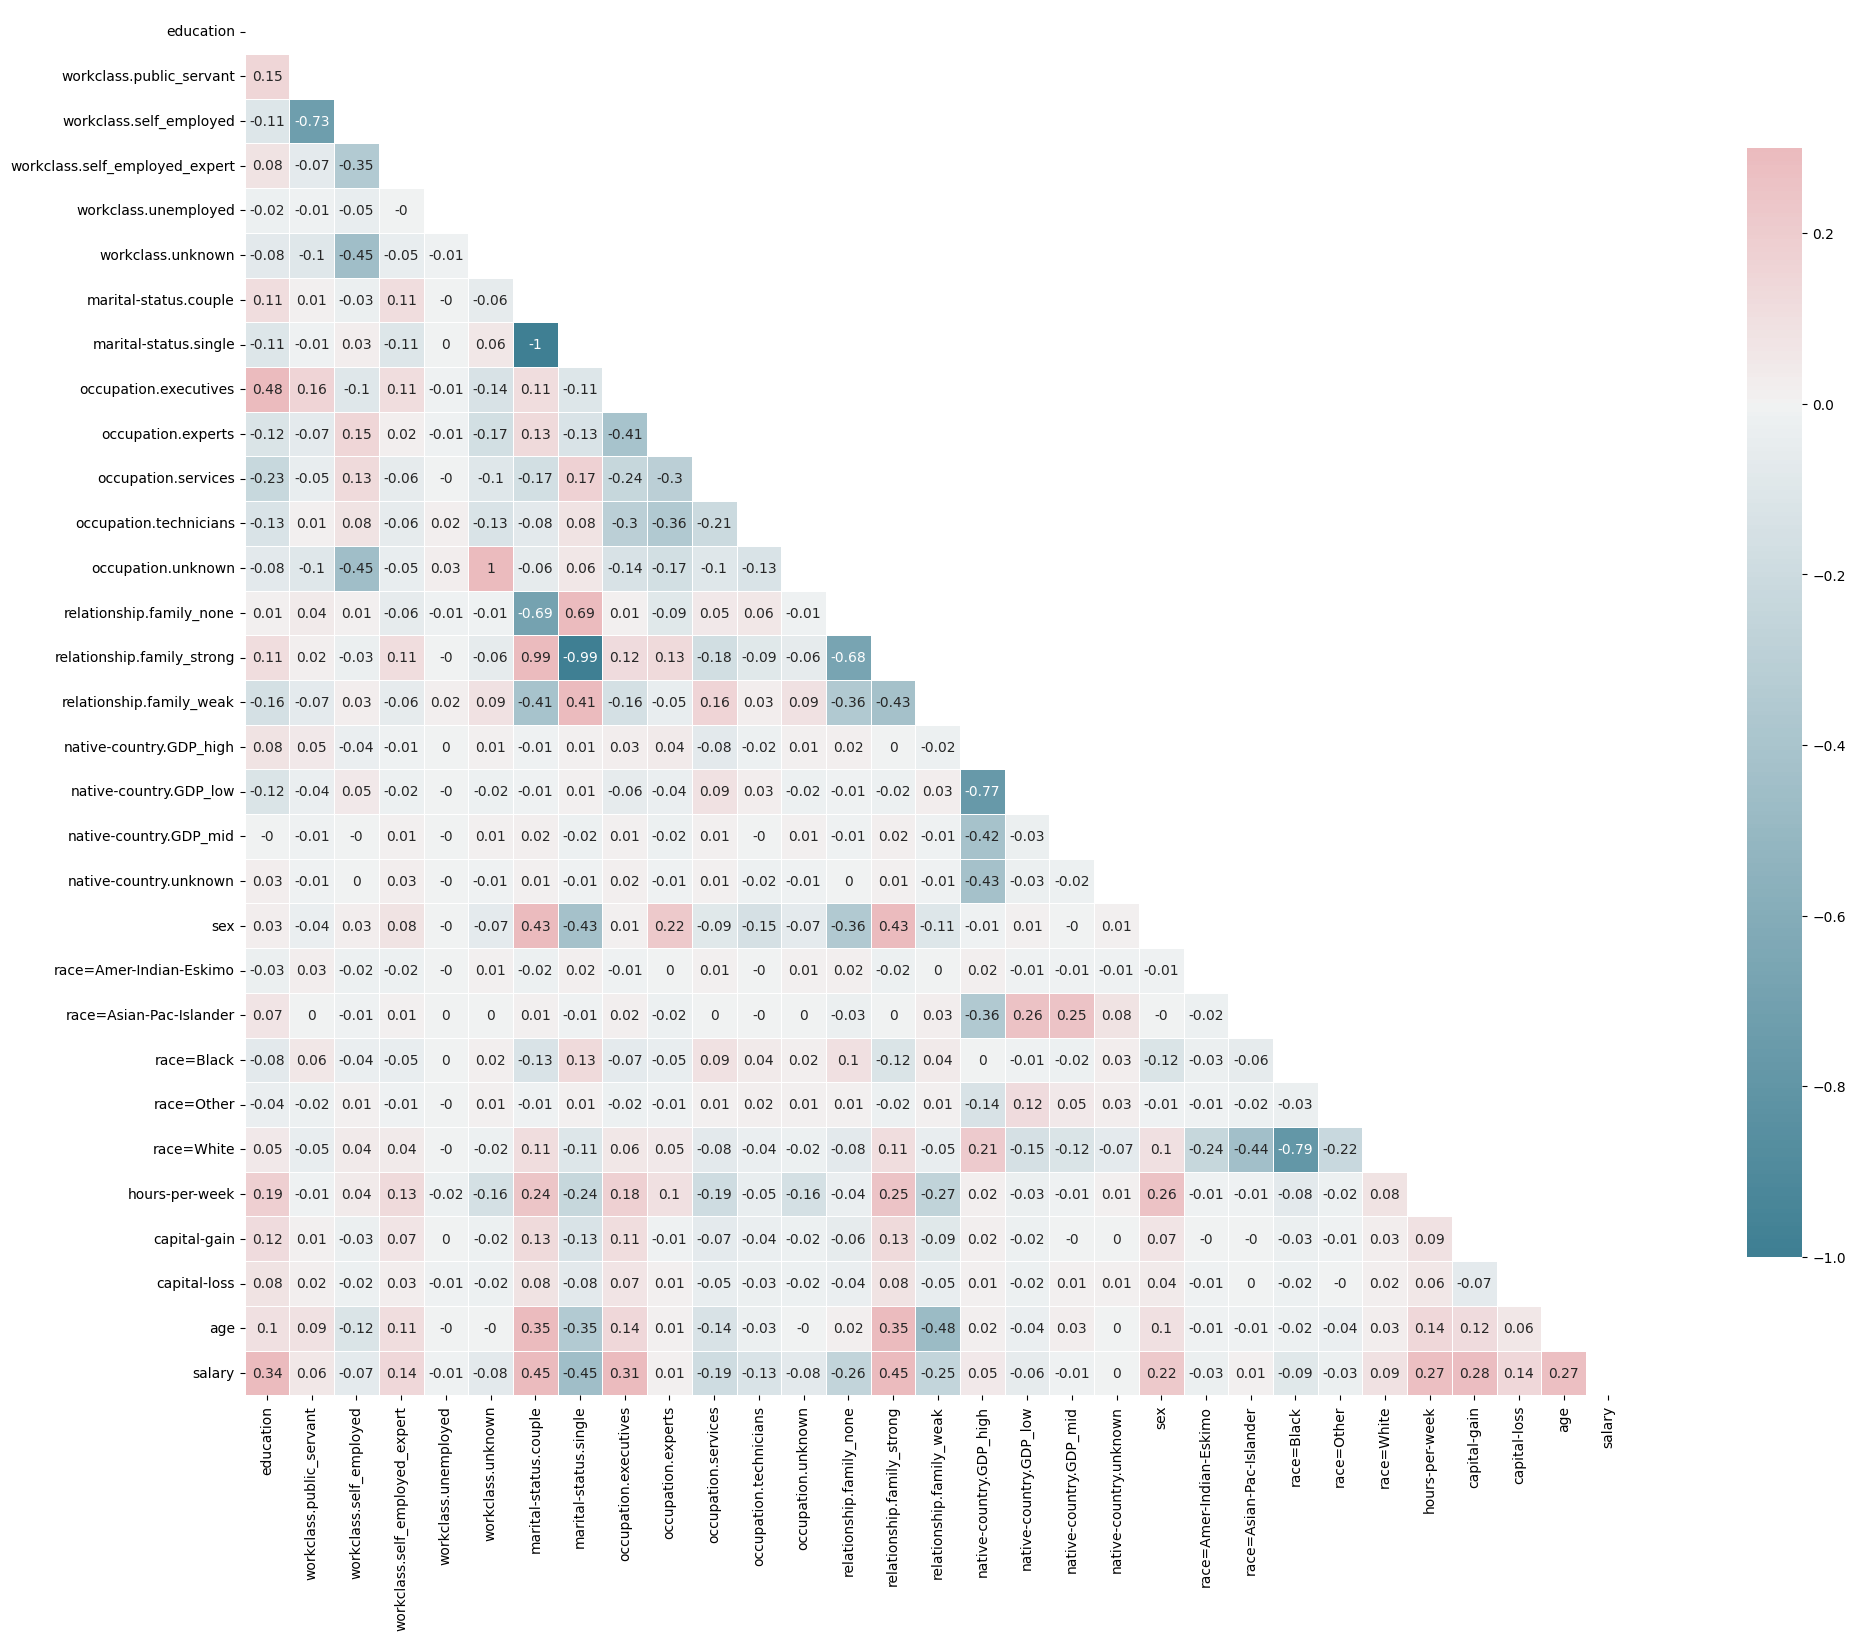

In [338]:
# Evaluation correlations
corr_matrix = evaluate_correlation(training_dataset)

# Generate a correlation matrix heat map
plot_correlation(corr_matrix, width=30)

Having irrelevant features in the data can decrease the accuracy of the models and force the model to learn irrelevant features.

We can now see a break-down of the feature importance with regard to the "salary" variable and remove all features that have a very low correlation.

In [339]:
# Filter features above a certain correlation threshold 
threshold = 0.05
feature_list_clean = corr_matrix["salary"].loc[abs(corr_matrix["salary"]) > threshold].index.tolist()

# Printing remaining features
print( "Remaining features:")
print("\n".join(feature_list_clean))


Remaining features:
education
workclass.public_servant
workclass.self_employed
workclass.self_employed_expert
workclass.unknown
marital-status.couple
marital-status.single
occupation.executives
occupation.services
occupation.technicians
occupation.unknown
relationship.family_none
relationship.family_strong
relationship.family_weak
native-country.GDP_low
sex
race=Black
race=White
hours-per-week
capital-gain
capital-loss
age
salary


# 6. Classification models definition and training

In the sections below we will define the various models and their hyper-parameters search space, then run the models in various conditions:
- first, without CV and with "standard" parameters.
- Second, using CV with "standard" parameters.
- Third, using CV and performing a search over a grid of tuning parameters.
- Finally a couple of models have been ran with a very large grid search to evaluate if the improvement in metric was worth the intense computation cost.   

## 6.1 Define models and hyperparameters

In [340]:

stacking_models_list = [
                        ('bagging', BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200)), 
                        ('RandForest', RandomForestClassifier(n_estimators=200)), 
                        ('AdaLogit', AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=200)),
                        ('AdaTree', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=200)), 
                        ('Tree', DecisionTreeClassifier()), 
                        ('Lbgm', LGBMClassifier()),
                        ('LogisticReg', LogisticRegression(max_iter=500))
                        ]

models_dict_list = [
            {"name": "CatBoost", "model": CatBoostClassifier(verbose=False, loss_function='Logloss'),    # WORKS
                    "params": {'n_estimators' : Integer(100,1000),
                               'max_depth' : Integer(3,10),
                               } },
            
            {"name": "Lbgm", "model": LGBMClassifier(objective='binary'),                      ## WORKS
                    "params": {'n_estimators' : Integer(100,500),
                              'learning_rate': Real(1e-6, 1, prior='log-uniform'),
                              #'boosting_type': Categorical(['gbdt', 'dart', 'goss', 'rf']),
                              'min_child_samples':  Integer(10,30) 
                              } },

            {"name": "XGBoost", "model": XGBClassifier(objective = 'binary:logistic'),             # WORKS
                    "params": {'n_estimators' : Integer(100,500),
                                # 'learning_rate': Real(1e-6, 1, prior='log-uniform'),
                                'subsample': Real(0.3, 0.9, prior='log-uniform'),
                                'max_depth': Integer(2,10), 
                                'colsample_bytree': Real(0.5, 0.9, prior='log-uniform'),
                                'min_child_weight': Integer(1,5),
                                } }, 
            
            {"name": "SGDC", "model": SGDClassifier(eta0 = 0.1, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10),  # WORKS
                "params" : {'loss': Categorical(['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']),  
                            'penalty' : Categorical(['l1', 'l2']),
                            'alpha': Real(1e-6, 1e+6, prior='log-uniform'), 
                            'fit_intercept': Categorical([True, False]),
                            'learning_rate': Categorical(['optimal', 'invscaling', 'adaptive']), 
                            'penalty' : Categorical(['l1', 'l2']) } },
            
            {"name": "LogisticReg", "model": LogisticRegression(max_iter=500, solver = 'liblinear'), # WORKS
                    "params": {'C': Real(1e-6, 1e+6, prior='log-uniform'), 
                               'penalty' : Categorical(['l1', 'l2']) } },
            
            {"name": "NaiveBayes", "model": GaussianNB(),                                                            # WORKS
                    "params": {'var_smoothing': Real(1e-6, 1e+2, prior='log-uniform')} },
            
            {"name": "LinearSupportVectClass", "model": LinearSVC(max_iter=1000, dual=True, tol=0.0001, verbose=0),  # WORKS
                "params": {'loss': Categorical(['hinge', 'squared_hinge']),
                           'C': Real(1e-6, 1e+6, prior='log-uniform'), 
                           'fit_intercept': Categorical([True, False]), } },
            
            ## {"name": "SupportVectClass", "model": SVC(max_iter=-1),        # Impractical for large datasets, grid search unrealistic
            ##     "params": {'C': Real(1e-6, 1e+6, prior='log-uniform'), 
            ##                 'gamma': Real(1e-6, 1.0, prior='log-uniform'), 
            ##                 'degree': Integer(1,8), 
            ##                 'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid'])  } },
            
           {"name": "kNN", "model": KNeighborsClassifier(),                                                       # WORKS
               "params": {'n_neighbors': Integer(3,10), 
                           'weights': Categorical(['uniform', 'distance']),
                           # 'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
                           'leaf_size': Integer(20,50),} },
           
            {"name": "RandForest", "model": RandomForestClassifier(),                   # WORKS
                "params": {'n_estimators' : Integer(100,500),
                           'criterion' : Categorical(['gini', 'entropy', 'log_loss']),
                           'min_samples_split': Integer(2,10),
                           'min_samples_leaf':  Integer(1,10),
                           'max_features': Categorical(['sqrt', 'log2']),
                           } },
            
            {"name": "XtraTree", "model": ExtraTreesClassifier(),                       # WORKS
                "params": {'n_estimators' : Integer(100,500),
                           'criterion' : Categorical(['gini', 'entropy', 'log_loss']),
                            'min_samples_split': Integer(2,10),
                           'min_samples_leaf':  Integer(1,10),
                           'max_features': Categorical(['sqrt', 'log2']) } },
            
            {"name": "GradBoost", "model": GradientBoostingClassifier(loss='log_loss'),                 # WORKS
                    "params": {'learning_rate': Real(1e-6, 1, prior='log-uniform'),
                               'n_estimators' : Integer(100,500),
                                'criterion' : Categorical(['friedman_mse', 'squared_error']),
                                'min_samples_leaf':  Integer(1,10),
                                'max_features': Categorical(['sqrt', 'log2']) } },
            
            {"name": "DecisionTree", "model": DecisionTreeClassifier(),                                # WORKS
                    "params": {'criterion' : Categorical(['gini', 'entropy', 'log_loss']),
                               'splitter': Categorical(['best', 'random']),
                               'max_depth': Integer(3,50), 
                               'min_samples_split':  Integer(2,10),
                               'min_samples_leaf':  Integer(1,10),
                                'max_features': Categorical(['sqrt', 'log2']) } },
            
            {"name": "Ada_Logit", "model": AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=500, solver = 'liblinear')),   # WORKS
                    "params": {'n_estimators' : Integer(30,100),
                               'learning_rate': Real(1e-6, 1, prior='log-uniform') } },
            
            {"name": "Ada_perceptron", "model": AdaBoostClassifier(base_estimator=Perceptron(), algorithm='SAMME'),     # WORKS
                    "params": {'n_estimators' : Integer(30,100),
                               'learning_rate': Real(1e-6, 1, prior='log-uniform') } },
            
            {"name": "Ada_SGDC", "model": AdaBoostClassifier(base_estimator=SGDClassifier(eta0 = 0.1, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10), algorithm='SAMME'),   # WORKS
                    "params": {'n_estimators' : Integer(30,100),
                               'learning_rate': Real(1e-6, 1, prior='log-uniform') } },
            
            {"name": "Bagging_Logit", "model": BaggingClassifier(base_estimator=LogisticRegression(max_iter=500, solver = 'liblinear')),    # WORKS
                    "params": {'n_estimators' : Integer(10,200),
                               'max_features': Real(1e-6, 1, prior='log-uniform'),
                               'bootstrap_features': Categorical([True, False]) } },
            
            {"name": "Bagging_tree", "model": BaggingClassifier(base_estimator=DecisionTreeClassifier()),   # WORKS
                    "params": {'n_estimators' : Integer(10,200),
                               'max_features': Real(1e-6, 1, prior='log-uniform'),
                               'bootstrap_features': Categorical([True, False]) } },
            
            {"name": "Stacking", "model": StackingClassifier(stacking_models_list, final_estimator=GradientBoostingClassifier()),   # WORKS
                  "params": {} },
            ]
               

## 6.2 Standard model training (no CV, no hyper-parameters)

In [407]:
# training data
X_train = train_df.drop('salary', axis=1)
X_test = test_df.drop('salary', axis=1)

# label encoding: 1 for >50k
y_train = (train_df['salary'] == '>50K') * 1.0
y_test = (test_df['salary'] == '>50K') * 1.0


### Let's run each model with their default parameters and evaluate metrics

========== Running model: CatBoost (duration: 0:00:11)
==> Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.84      0.89     12435
         1.0       0.61      0.83      0.70      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.83      0.80     16281
weighted avg       0.86      0.84      0.84     16281

==> Confusion_matrix:
 [[10402  2033]
 [  650  3196]]

========== Running model: Lbgm (duration: 0:00:08)
==> Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.84      0.89     12435
         1.0       0.61      0.83      0.70      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.83      0.79     16281
weighted avg       0.86      0.84      0.84     16281

==> Confusion_matrix:
 [[10418  2017]
 [  662  3184]]

========== Running model: XGBoost (duration: 0:00:11)
==> Classification r

/home/albator/.cache/pypoetry/virtualenvs/adv-ml-techniques-for-imbalanced-dataset-6BVEZe3K-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 (duration: 0:00:12)
==> Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.78      0.85     12435
         1.0       0.54      0.84      0.66      3846

    accuracy                           0.79     16281
   macro avg       0.74      0.81      0.76     16281
weighted avg       0.85      0.79      0.81     16281

==> Confusion_matrix:
 [[9691 2744]
 [ 610 3236]]
No feature importance method.
========== Running model: kNN (duration: 0:00:07)
==> Classification report:
               precision    recall  f1-score   support

         0.0       0.90      0.85      0.88     12435
         1.0       0.59      0.70      0.64      3846

    accuracy                           0.81     16281
   macro avg       0.75      0.77      0.76     16281
weighted avg       0.83      0.81      0.82     16281

==> Confusion_matrix:
 [[10586  1849]
 [ 1169  2677]]
No feature importance method.
========== Running model: RandForest (duration: 0:00:09

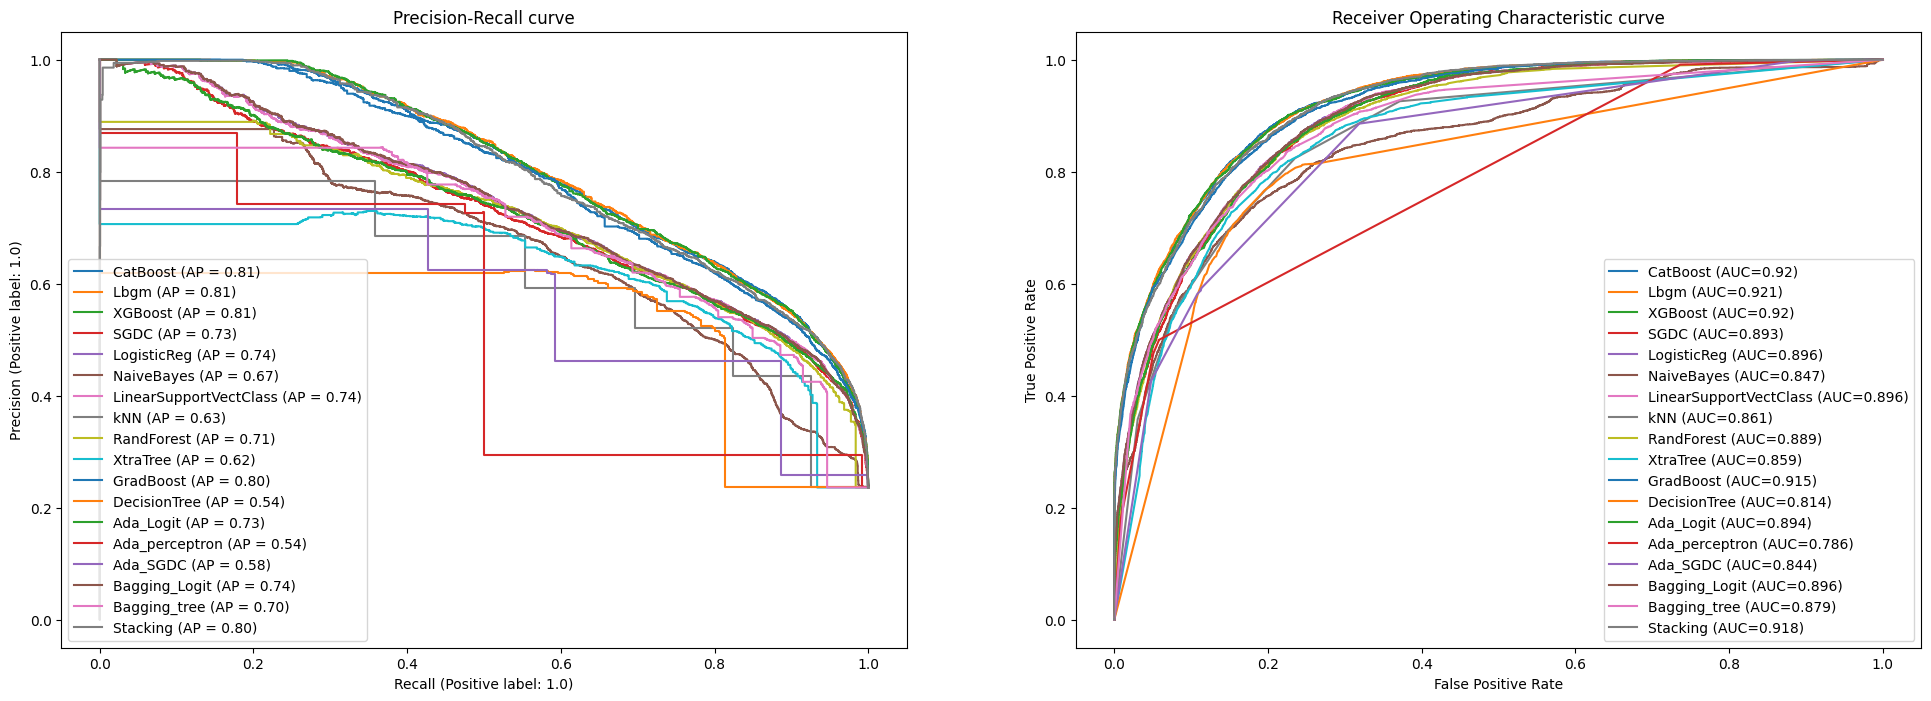

=== RESULTS SUMMARY ===


,precision,recall,f1-score,accuracy,AUC score
Model,,,,,
CatBoost,0.863,0.835,0.843,0.835,0.920
Lbgm,0.863,0.835,0.843,0.835,0.921
Stacking,0.859,0.836,0.843,0.836,0.918
XGBoost,0.862,0.834,0.842,0.834,0.920
GradBoost,0.858,0.821,0.830,0.821,0.915
RandForest,0.843,0.819,0.827,0.819,0.889
Ada_perceptron,0.828,0.837,0.826,0.837,0.786
Bagging_tree,0.840,0.818,0.825,0.818,0.879
XtraTree,0.835,0.815,0.822,0.815,0.859


In [235]:
fig, axes = plt.subplots(1,2, figsize=(24,8))
 
results_df = pd.DataFrame(columns=['Model', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score'])
feat_list = training_dataset.columns.drop('salary')
feature_importance_df = pd.DataFrame(index=feat_list)

for model_dict in models_dict_list:
    
    # Extract model
    model_name = model_dict["name"]
    model = model_dict["model"]
    
    # Build pipeline with specific model
    full_pipe_df = Pipeline([ ('smotenc', SMOTENC(categorical_features=categorical_feature_mask, sampling_strategy="minority")),
                              ('Feats', FeatureUnion_CT(Feats)),  
                              (model_name, model)
                            ])
    
    # Training model
    print("========== Running model: "+model_name, end='')
    start_time = datetime.now()
    full_pipe_df.fit(X_train, y_train)
    
    # Prediction
    y_true = y_test.to_numpy()
    y_pred = full_pipe_df.predict(X_test)
    
    print(' (duration: {})'.format(str(datetime.now() - start_time).split('.')[0]))
    
    # Evaluate probabilities
    try:
        y_predict_proba = full_pipe_df.predict_proba(X_test)[:,1]
    except AttributeError:
        y_predict_proba = full_pipe_df.decision_function(X_test)  

    # Print metrics reports
    class_report = classification_report(y_true, y_pred)
    print("==> Classification report:\n",class_report)
    confus_matrix = confusion_matrix(y_true, y_pred)
    print("==> Confusion_matrix:\n",confus_matrix)
    
    # Evauate metrics for weighted support
    accuracy = accuracy_score(y_true, y_pred)
    P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division = 0)

    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)    
    auc_score = auc(fpr, tpr)
    
    # Evaluate Features importance (if method exists)
    try:
        feature_importance_df[model_name] = pd.DataFrame(full_pipe_df[2].feature_importances_, index=feat_list)
        print()
    except:
        print("No feature importance method.")
        
    # Store parameters
    results_df.loc[len(results_df.index)] = [model_name, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3)]
    
    # Plot PR curve
    PrecisionRecallDisplay.from_estimator(full_pipe_df, X_test, y_test, ax = axes[0], name=model_name)
    axes[0].set_title('Precision-Recall curve',fontsize = 12)
    axes[0].grid()
    
    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax = axes[1], name=model_name+" (AUC="+str(round(auc_score,3))+")")
    axes[1].set_title('Receiver Operating Characteristic curve',fontsize = 12)
    axes[1].legend(loc="lower right")
    axes[1].grid()

plt.show()
print("=== RESULTS SUMMARY ===")
results_df = results_df.set_index('Model')
results_df.sort_values("f1-score", inplace = True, ascending=False)
results_df
    

F1-score is the best suited metric for imbalance dataset as it takes into account recall and precision.

Furthermore, since we balanced the datatset using SMOTE, looking at the ROC-AUC curve should provide additional information on how the model segregates True Positive Rate vs False Positive Rate.   

The P-R curve is also a very good visual measure to compare precision vs recall.   

A good classifier should have both high precision and high recall.   
In other words a good classifier should be good at whatever it predicted (high precision) but also good at picking the correct items (high recall).

### Features importance (if method exists )

In [236]:
feature_importance_df

,CatBoost,Lbgm,XGBoost,RandForest,XtraTree,GradBoost,DecisionTree
education,7.696391,192,0.036978,0.098481,0.077721,0.138573,0.126873
workclass.public_servant,0.868707,42,0.004410,0.005350,0.004463,0.000990,0.009138
workclass.self_employed,0.585969,43,0.003536,0.005918,0.004860,0.000000,0.010468
workclass.self_employed_expert,0.353163,32,0.003249,0.003512,0.003336,0.000331,0.005464
workclass.unemployed,0.017485,0,0.001742,0.000091,0.000183,0.000000,0.000067
workclass.unknown,0.545019,6,0.002688,0.001371,0.002350,0.000000,0.001174
marital-status.couple,5.178690,66,0.034151,0.065517,0.091831,0.005816,0.001055
marital-status.single,4.038792,16,0.000000,0.102592,0.081665,0.011203,0.000820
occupation.executives,2.642956,67,0.031239,0.041935,0.057306,0.050240,0.012770
occupation.experts,1.324374,60,0.007408,0.007341,0.009141,0.009849,0.008573


This table is somewhat a bit inconsistent.   
It is assumed that the different algorithms have a different implementation of the method leading to different perceptions of which features are important. 

array([<AxesSubplot:title={'center':'CatBoost'}>,
       <AxesSubplot:title={'center':'Lbgm'}>,
       <AxesSubplot:title={'center':'XGBoost'}>,
       <AxesSubplot:title={'center':'RandForest'}>,
       <AxesSubplot:title={'center':'XtraTree'}>,
       <AxesSubplot:title={'center':'GradBoost'}>,
       <AxesSubplot:title={'center':'DecisionTree'}>], dtype=object)

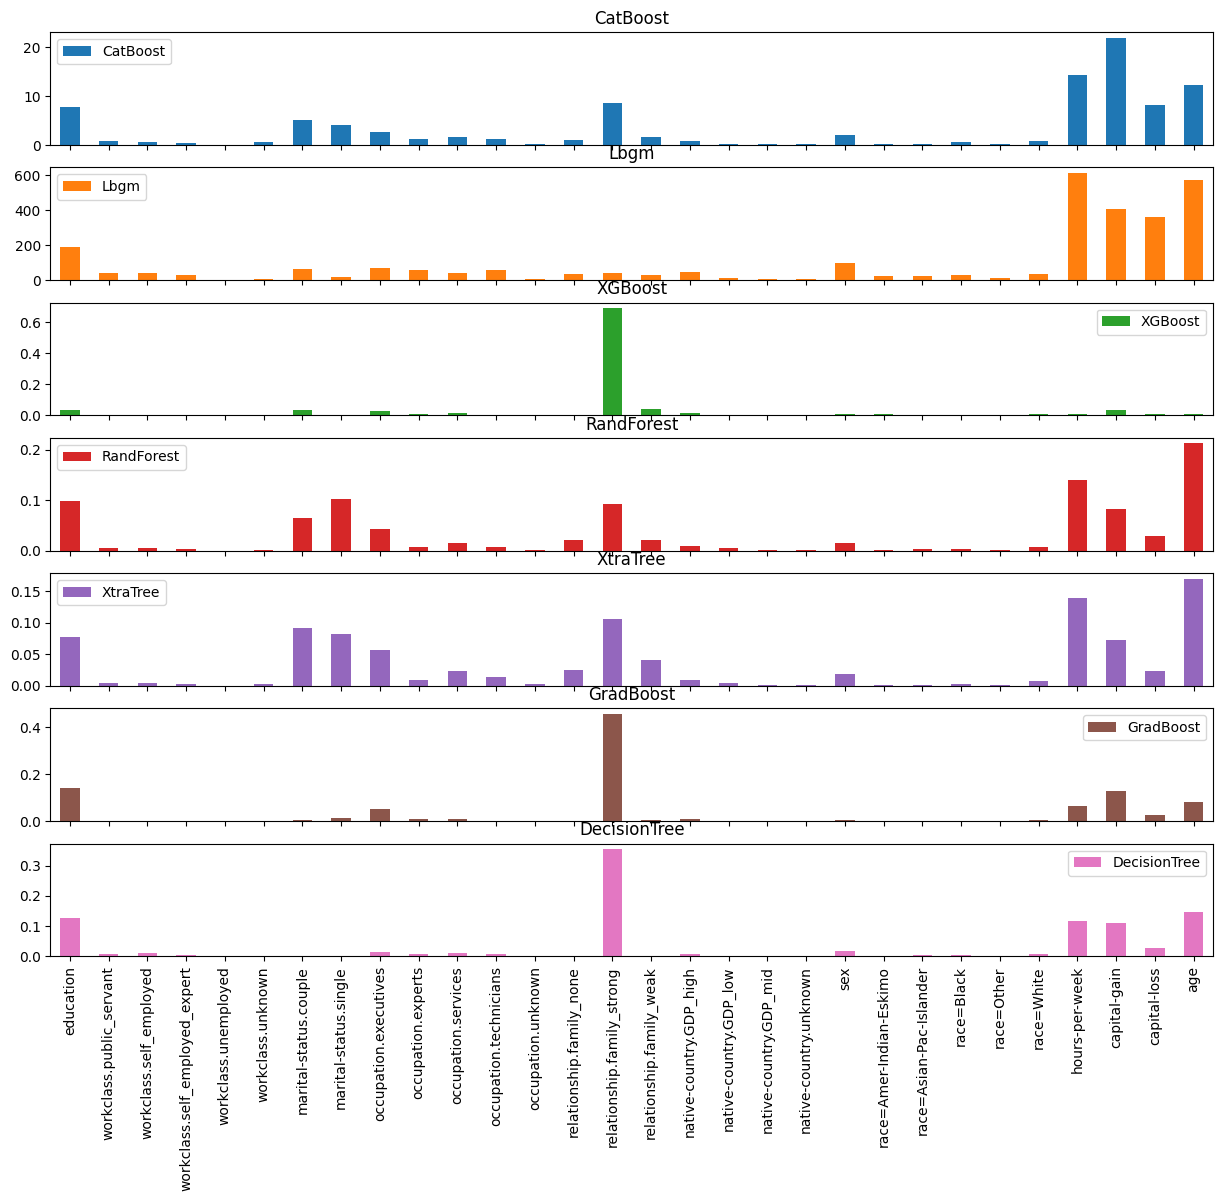

In [265]:
feature_importance_df.plot.bar(rot=90, subplots=True, figsize=(15,12) )

## 6.3 Run each model again using StratifiedKFold Cross-Validation and evaluate metrics

Note that this time, the pipelin does not include SMOTENC as StratifiedKFold ensures equal representation of classes.

In [408]:
CV_results_df = pd.DataFrame(columns=['Model', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score'])

N_folds = 5

for model_dict in models_dict_list:

    # Prepare CV
    sKF = StratifiedKFold(n_splits=N_folds, shuffle=True)
    fold_results_df = pd.DataFrame(columns=['Fold', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score'])

    # Extract model
    model_name = model_dict["name"]
    model = model_dict["model"]
    
    # Build pipeline with specific model
    pipe = Pipeline([('Feats', FeatureUnion_CT(Feats)), 
                     (model_name, model)
                    ])  

    # Build CV model list 
    fold_model_list = [pipe for _ in range(N_folds)]

    # Training model
    print("========== Running model: "+model_name)

    fold_no = 0
    print("==== Training fold: ", end='') 
    for train_index, val_index in sKF.split(X_train, y_train):

        # Training model on fold x
        print(str(fold_no)+" ", end='')    
        print("train_index, val_index", len(train_index), len(val_index))    

        # Splitting datasets
        X_train_CV, y_train_CV = X_train.loc[train_index,:], y_train.loc[train_index]
        X_val_CV, y_val_CV = X_train.loc[val_index,:], y_train.loc[val_index]
        
        print("X_train_CV, y_train_CV:",len(X_train_CV), len(y_train_CV))
        print("X_val_CV, y_val_CV:",len(X_val_CV), len(y_val_CV))
        
        # Training model and predicting
        fold_model_list[fold_no].fit(X_train_CV, y_train_CV)
        y_true = y_val_CV.to_numpy()
        y_pred = fold_model_list[fold_no].predict(X_val_CV)         
        
        print("y_true, y_pred:",len(y_true), len(y_pred))
     
        # Evauate metrics for weighted support
        accuracy = accuracy_score(y_true, y_pred)
        P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division = 0)
        
        # Store parameters for the BEST F1-score model (arbitrary selected)
        fold_results_df.loc[len(fold_results_df.index)] = [fold_no, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3)]
        # print(fold_results_df)
        
        # next fold
        fold_no += 1

    # print results of the sKF validation
    print()
    fold_results_df.sort_values("f1-score", inplace = True, ascending=False)
    
    # select the BEST and WORST F1-score models and evaluate metrics on the TEST dataset
    best_fold_no = int(fold_results_df.iloc[0]["Fold"])    
    worst_fold_no = int(fold_results_df.iloc[N_folds-1]["Fold"])    
    
    # Display the fold model results
    tmp_df = fold_results_df.set_index('Fold')
    print(tmp_df)
    print("best fold No:", str(best_fold_no), "- worst fold No:", str(worst_fold_no))
    
    # Evaluate metrics for BEST F1-score model 
    y_pred = fold_model_list[best_fold_no].predict(X_val_CV) 
    accuracy = accuracy_score(y_true, y_pred)
    P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    # Store parameters for the BEST F1-score model
    CV_results_df.loc[len(CV_results_df.index)] = [model_name, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3)]
    
    
# Display all BEST f1-score models 
print("========== BEST f1-score models:")
CV_results_df = CV_results_df.set_index('Model')
CV_results_df.sort_values("f1-score", inplace = True, ascending=False)
CV_results_df

========== Running model: CatBoost
==== Training fold: 0 train_index, val_index 26048 6513


CatBoostError: Length of label=26048 and length of data=20840 is different.

In [393]:
# training data
X_train = train_df.drop('salary', axis=1)
y_train = (train_df['salary'] == '>50K') * 1.0

X_test = test_df.drop('salary', axis=1)
y_test = (test_df['salary'] == '>50K') * 1.0


In [398]:
from sklearn.base import clone 
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

In [401]:
X_train_CV, y_train_CV = X_train.loc[train_index,:], y_train.loc[train_index]
X_val_CV, y_val_CV = X_train.loc[val_index,:], y_train.loc[val_index]

# print(X_train_CV)
# print(y_train_CV)

# print(X_val_CV)
# print(y_val_CV)

In [402]:
pipe = Pipeline([   ('smotenc', SMOTENC(categorical_features=categorical_feature_mask, sampling_strategy="minority")),
                            ('Feats', FeatureUnion_CT(Feats)),  
                            (model_name, model)
                        ])  

# Build CV model list 
# model = clone(pipe_tmp) 

pipe2 = deepcopy(pipe)
    

In [403]:
pipe2.fit(X_train_CV, y_train_CV)

ValueError: could not convert string to float: 'elem_school'

In [300]:
y_pred = fold_model_list[fold_no].predict(X_val_CV)   
len(X_val_CV)

6513

Note that the best of the K-fold models was selected.    
This gives an over-estimate of the performance of the model.   
This choice is arbitrary and only meant to highlighting the difference between K-fold models.    
A more fair approach would have been to average the F-score over the K-folds.   

In [308]:
print("X_train_CV, y_train_CV:",len(X_train_CV), len(y_train_CV))
print("X_val_CV, y_val_CV:",len(X_val_CV), len(y_val_CV))

full_pipe_df.fit(X_train_CV, y_train_CV)

X_train_CV, y_train_CV: 26048 26048
X_val_CV, y_val_CV: 6513 6513


Pipeline(steps=[('smotenc',
                 SMOTENC(categorical_features=age               False
workclass         True 
education         True 
marital-status    True 
occupation        True 
relationship      True 
race              True 
sex               True 
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    True 
dtype: bool,
                         sampling_strategy='minority')),
                ('Feats',
                 FeatureUnion_CT(transformer_list=[('categorical Ordinal',
                                                    Pipeline(steps=[('e...
                                                                     <__main__.ColumnExtractor_CT object at 0x7feb168efe20>),
                                                                    ('StdScaler',
                                                                     StdScaler_CT(columns=['hours-per-week',
                                                                                           'capital-gain',
                                                                                           'capital-loss']))])),
                                                   ('numerical MinMaxScaler',
                                                    Pipeline(steps=[('extract',
                                                                     <__main__.ColumnExtractor_CT object at 0x7feb168efe80>),
                                                                    ('MinMaxScaler',
                                                                     MinMaxScaler_CT(columns=['age']))]))])),
                ('clf',
                 LogisticRegression(C=0.123164, max_iter=500, penalty='l1',
                                    solver='liblinear'))])

In [309]:
y_true = y_val_CV.to_numpy()
y_pred = full_pipe_df.predict(X_val_CV)

print("y_true, y_pred:",len(y_true), len(y_pred))

y_true, y_pred: 6513 1330


## 6.4 Search a grid of hyper-parameters to find the best classifier (quick run)

In [88]:

results_df = pd.DataFrame(columns=['Model', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score', 'Best params'])

N_folds = 5

for model_dict in models_dict_list:
    
    # Skip to the next model if no parameters
    model_name = model_dict["name"]    
    if model_dict["params"] == {}:
        continue
    
    # Define search grid
    search = BayesSearchCV(estimator = model_dict["model"],
                           search_spaces = model_dict["params"],
                           n_iter = 50,
                           scoring = 'f1_weighted', # 'f1', f1_weighted', 'roc_auc', 'accuracy'
                        #    optimizer_kwargs = {'base_estimator': 'RF'},
                           n_jobs = 8, # change based on how many cpus available (8 for me)
                           n_points = 8, # change based on how many cpus available (8 for me)
                           cv = N_folds, # default: StratifiedKFold for binary labels
                           refit = True,
                           verbose = 0,
                           error_score = 'raise', 
                           return_train_score  = True,        
                            )
    
    # Training model
    print("========== Running model: "+model_name, end='')
    start_time = datetime.now()
    _ = search.fit(X_train, y_train)
    print(' (duration: {})'.format(str(datetime.now() - start_time).split('.')[0]))
    
    # Print results
    print("Best validation score: ", round(search.best_score_, 3))
    print("Best search parameters: ", search.best_params_)
    print("Test score: ", round(search.score(X_test, y_test), 3))
    
    best_model = search.best_estimator_
    cv_results = search.cv_results_
    
    y_true = y_test.to_numpy()
    y_pred = best_model.predict(X_test) 
    
    # Evauate metrics for weighted support
    accuracy = accuracy_score(y_true, y_pred)
    P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    
    # Evaluate probabilities and auc_score
    try:
        y_predict_proba = best_model.predict_proba(X_test)[:,1]
    except AttributeError:
        y_predict_proba = best_model.decision_function(X_test)  

    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)    
    auc_score = auc(fpr, tpr)
    
    # Store parameters
    results_df.loc[len(results_df.index)] = [model_name, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3), search.best_params_]
    
print("=== BEST MODEL RESULTS SUMMARY ===")
results_df = results_df.set_index('Model')
results_df.sort_values("f1-score", inplace = True, ascending=False)
results_df  

========== Running model: CatBoost

 (duration: 0:22:49)
Best validation score:  0.881
Best search parameters:  OrderedDict([('max_depth', 7), ('n_estimators', 308)])
Test score:  0.762
========== Running model: Lbgm (duration: 0:02:01)
Best validation score:  0.881
Best search parameters:  OrderedDict([('learning_rate', 0.057854998660953644), ('min_child_samples', 30), ('n_estimators', 424)])
Test score:  0.781
========== Running model: XGBoost (duration: 0:08:24)
Best validation score:  0.882
Best search parameters:  OrderedDict([('colsample_bytree', 0.5), ('max_depth', 6), ('min_child_weight', 2), ('n_estimators', 100), ('subsample', 0.9)])
Test score:  0.761
========== Running model: SGDC (duration: 0:00:52)
Best validation score:  0.856
Best search parameters:  OrderedDict([('alpha', 1e-06), ('fit_intercept', True), ('learning_rate', 'adaptive'), ('loss', 'log_loss'), ('penalty', 'l2')])
Test score:  0.812
========== Running model: LogisticReg (duration: 0:01:25)
Best validation score:  0.857
Best search parameters:

 (duration: 0:07:58)
Best validation score:  0.854
Best search parameters:  OrderedDict([('leaf_size', 38), ('n_neighbors', 9), ('weights', 'uniform')])
Test score:  0.811
========== Running model: RandForest

 (duration: 0:09:57)
Best validation score:  0.875
Best search parameters:  OrderedDict([('criterion', 'entropy'), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 10), ('n_estimators', 478)])
Test score:  0.815
========== Running model: XtraTree

 (duration: 0:08:58)
Best validation score:  0.869
Best search parameters:  OrderedDict([('criterion', 'log_loss'), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 466)])
Test score:  0.814
========== Running model: GradBoost (duration: 0:03:38)
Best validation score:  0.88
Best search parameters:  OrderedDict([('criterion', 'squared_error'), ('learning_rate', 0.37038155176265125), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('n_estimators', 448)])
Test score:  0.736
========== Running model: DecisionTree (duration: 0:00:35)
Best validation score:  0.865
Best search parameters:  OrderedDict([('criterion', 'log_loss'), ('max_depth', 21), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 10), ('splitter', 'best')])
Test score:  0.814
========== Running model: Ada_Logit

 (duration: 0:07:23)
Best validation score:  0.852
Best search parameters:  OrderedDict([('learning_rate', 0.9537833182923252), ('n_estimators', 100)])
Test score:  0.808
========== Running model: Ada_perceptron (duration: 0:03:50)
Best validation score:  0.856
Best search parameters:  OrderedDict([('learning_rate', 8.13201330965181e-05), ('n_estimators', 32)])
Test score:  0.819
========== Running model: Ada_SGDC (duration: 0:06:35)
Best validation score:  0.846
Best search parameters:  OrderedDict([('learning_rate', 0.10157572775991612), ('n_estimators', 100)])
Test score:  0.807
========== Running model: Bagging_Logit

 (duration: 0:15:11)
Best validation score:  0.857
Best search parameters:  OrderedDict([('bootstrap_features', False), ('max_features', 1.0), ('n_estimators', 63)])
Test score:  0.812
========== Running model: Bagging_tree

 (duration: 0:03:35)
Best validation score:  0.875
Best search parameters:  OrderedDict([('bootstrap_features', True), ('max_features', 1.0), ('n_estimators', 200)])
Test score:  0.797
=== BEST MODEL RESULTS SUMMARY ===


,precision,recall,f1-score,accuracy,AUC score,Best params
Model,,,,,,
Ada_perceptron,0.841,0.810,0.819,0.810,0.891,"{'learning_rate': 8.13201330965181e-05, 'n_estimators': 32}"
RandForest,0.849,0.803,0.815,0.803,0.890,"{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 478}"
XtraTree,0.843,0.804,0.814,0.804,0.882,"{'criterion': 'log_loss', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 466}"
DecisionTree,0.837,0.804,0.814,0.804,0.873,"{'criterion': 'log_loss', 'max_depth': 21, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}"
SGDC,0.843,0.801,0.812,0.801,0.895,"{'alpha': 1e-06, 'fit_intercept': True, 'learning_rate': 'adaptive', 'loss': 'log_loss', 'penalty': 'l2'}"
LogisticReg,0.842,0.801,0.812,0.801,0.895,"{'C': 59553.866908126176, 'penalty': 'l1'}"
Bagging_Logit,0.843,0.801,0.812,0.801,0.895,"{'bootstrap_features': False, 'max_features': 1.0, 'n_estimators': 63}"
kNN,0.836,0.800,0.811,0.800,0.869,"{'leaf_size': 38, 'n_neighbors': 9, 'weights': 'uniform'}"
Ada_Logit,0.841,0.797,0.808,0.797,0.893,"{'learning_rate': 0.9537833182923252, 'n_estimators': 100}"


The F-score are lower than the results above using the stratifiedKfold.    
This time the F-score represents an average over ALL folds for the parameters that give, overall, the best score. 

## 6.5 Search a grid of hyper-parameters to find the best classifier 
More folds, more iterations (example 1: Catboost)

In [16]:

results_df = pd.DataFrame(columns=['Model', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score', 'Best params'])

N_folds = 10

for model_dict in models_dict_list:
    
    # Skip to the next model if no parameters
    model_name = model_dict["name"]    
    if model_dict["params"] == {}:
        continue
    
    # Define search grid
    search = BayesSearchCV(estimator = model_dict["model"],
                           search_spaces = model_dict["params"],
                           n_iter = 100,
                           scoring = 'f1_weighted', # 'f1', f1_weighted', 'roc_auc', 'accuracy'
                        #    optimizer_kwargs = {'base_estimator': 'RF'},
                           n_jobs = 8, # change based on how many cpus available (8 for me)
                           n_points = 8, # change based on how many cpus available (8 for me)
                           cv = N_folds, # default: StratifiedKFold for binary labels
                           refit = True,
                           verbose = 1,
                           error_score = 'raise', 
                           return_train_score  = True,        
                            )
    
    # Training model
    print("========== Running model: "+model_name, end='')
    start_time = datetime.now()
    _ = search.fit(X_train, y_train)
    print(' (duration: {})'.format(str(datetime.now() - start_time).split('.')[0]))
    
    # Print results
    print("Best validation score: ", round(search.best_score_, 3))
    print("Best search parameters: ", search.best_params_)
    print("Test score: ", round(search.score(X_test, y_test), 3))
    
    best_model = search.best_estimator_
    cv_results = search.cv_results_
    
    y_true = y_test.to_numpy()
    y_pred = best_model.predict(X_test) 
    
    # Evauate metrics for weighted support
    accuracy = accuracy_score(y_true, y_pred)
    P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    
    # Evaluate probabilities and auc_score
    try:
        y_predict_proba = best_model.predict_proba(X_test)[:,1]
    except AttributeError:
        y_predict_proba = best_model.decision_function(X_test)  

    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)    
    auc_score = auc(fpr, tpr)
    
    # Store parameters
    results_df.loc[len(results_df.index)] = [model_name, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3), search.best_params_]
    
print("=== BEST MODEL RESULTS SUMMARY ===")
results_df = results_df.set_index('Model')
results_df.sort_values("f1-score", inplace = True, ascending=False)
results_df  

========== Running model: CatBoostFitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits


Fitting 10 folds for each of 8 candidates, totalling 80 fits


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits


Fitting 10 folds for each of 8 candidates, totalling 80 fits


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
 (duration: 3:05:46)
Best validation score:  0.887
Best search parameters:  OrderedDict([('max_depth', 7), ('n_estimators', 954)])
Test score:  0.773
=== BEST MODEL RESULTS SUMMARY ===


,precision,recall,f1-score,accuracy,AUC score,Best params
Model,,,,,,
CatBoost,0.848,0.755,0.773,0.755,0.893,"{'max_depth': 7, 'n_estimators': 954}"


The F-score for the CatBoost classifier is slightly improved (from 0.743 to 0.55) by using more folds and more search points.   

Unfortunately running that many points is computationaly very expensive and I could only try out one classifier to demonstrate the point.

## 6.7 Search a grid of hyper-parameters to find the best classifier 
More folds, more iterations (example 2: Logistic regression)

In [19]:
models_dict_list = [
            {"name": "LogisticReg", "model": LogisticRegression(max_iter=500, solver = 'liblinear'), # WORKS
                    "params": {
                                'C': Real(1e-6, 1e+2, prior='log-uniform'), 
                            #    'penalty' : Categorical(['l1', 'l2']) 
                            }  }
]

In [20]:

results_df = pd.DataFrame(columns=['Model', 'precision', 'recall', 'f1-score', 'accuracy', 'AUC score', 'Best params'])

N_folds = 10

for model_dict in models_dict_list:
    
    # Skip to the next model if no parameters
    model_name = model_dict["name"]    
    if model_dict["params"] == {}:
        continue
    
    # Define search grid
    search = BayesSearchCV(estimator = model_dict["model"],
                           search_spaces = model_dict["params"],
                           n_iter = 80,
                           scoring = 'f1_weighted', # 'f1', f1_weighted', 'roc_auc', 'accuracy'
                        #    optimizer_kwargs = {'base_estimator': 'RF'},
                           n_jobs = 8, # change based on how many cpus available (8 for me)
                           n_points = 8, # change based on how many cpus available (8 for me)
                           cv = N_folds, # default: StratifiedKFold for binary labels
                           refit = True,
                           verbose = 1,
                           error_score = 'raise', 
                           return_train_score  = True,        
                            )
    
    # Training model
    print("========== Running model: "+model_name)
    start_time = datetime.now()
    _ = search.fit(X_train, y_train)
    print(' (duration: {})'.format(str(datetime.now() - start_time).split('.')[0]))
    
    # Print results
    print("Best validation score: ", round(search.best_score_, 3))
    print("Best search parameters: ", search.best_params_)
    print("Test score: ", round(search.score(X_test, y_test), 3))
    
    best_model = search.best_estimator_
    cv_results = search.cv_results_
    
    y_true = y_test.to_numpy()
    y_pred = best_model.predict(X_test) 
    
    # Evauate metrics for weighted support
    accuracy = accuracy_score(y_true, y_pred)
    P, R, F1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    
    # Evaluate probabilities and auc_score
    try:
        y_predict_proba = best_model.predict_proba(X_test)[:,1]
    except AttributeError:
        y_predict_proba = best_model.decision_function(X_test)  

    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)    
    auc_score = auc(fpr, tpr)
    
    # Store parameters
    results_df.loc[len(results_df.index)] = [model_name, round(P, 3), round(R, 3),  round(F1, 3), round(accuracy, 3), round(auc_score, 3), search.best_params_]
    
print("=== BEST MODEL RESULTS SUMMARY ===")
results_df = results_df.set_index('Model')
results_df.sort_values("f1-score", inplace = True, ascending=False)
results_df  

========== Running model: LogisticReg
Fitting 10 folds for each of 8 candidates, totalling 80 fits


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits


Fitting 10 folds for each of 8 candidates, totalling 80 fits
 (duration: 0:02:11)
Best validation score:  0.859
Best search parameters:  OrderedDict([('C', 2.9766708770995995)])
Test score:  0.812
=== BEST MODEL RESULTS SUMMARY ===


,precision,recall,f1-score,accuracy,AUC score,Best params
Model,,,,,,
LogisticReg,0.843,0.801,0.812,0.801,0.895,{'C': 2.9766708770995995}
